# Background

Problem statement: We want to recommend product categories based on products that customers purchased.

In this report, the dataset will be analyzed as a whole and in a narrow scope, consumer's state. By setting a threshold for the amount of orders in the dataset, we will do a consumers' state level analysis on the consumers' behaviour in that state.

# Methodology

We aim to investigate and develop our hypothesis by implementing Association Rule Learning to see what basket of products does general customers usually purchase together.

# 1. IMPORTING LIBRARIES

In [1]:
#from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sb
sb.set(font_scale=1.3)
import numpy as np
import nltk
import datetime as dt
# ! pip install mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


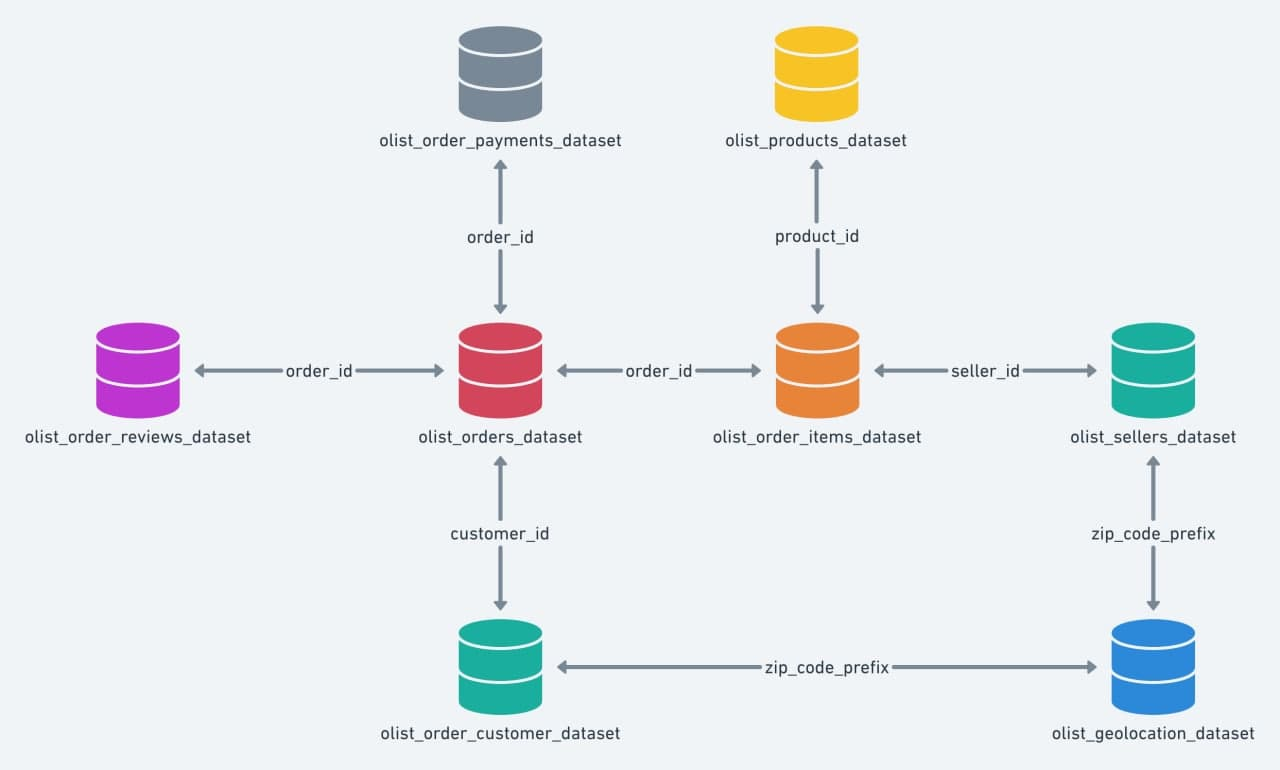

In [2]:
from IPython.display import Image
Image(filename = "olist_data_schema.jpg", width = 600, height = 300)

# 2. IMPORTING DATASETS

## 2.1 olist_orders_dataset

This is the core dataset. From each order you might find all other information

1) order_id: unique identifier of the order.

2) customer_id: key to the customer dataset. Each order has a unique customer_id.

3) order_purchase_timestamp: Shows the purchase timestamp.

4) order_delivered_customer_date: Shows the actual order delivery date to the customer.

In [3]:
order_dataset = pd.read_csv("olist_orders_dataset.csv")[['order_id', 'customer_id', 'order_purchase_timestamp']]
order_dataset.head()

,order_id,customer_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39


In [4]:
order_dataset.count()

order_id                    99441
customer_id                 99441
order_purchase_timestamp    99441
dtype: int64

In [5]:
order_dataset["order_id"].nunique()

99441

## 2.2 olist_order_items_dataset

This dataset includes data about the items purchased within each order.

1) order_id: order unique identifier

2) order_item_id: sequential number identifying number of items included in the same order.

3) product_id: product unique identifier

4) seller_id: seller unique identifier

5) price: item price

In [6]:
order_item_dataset = pd.read_csv("olist_order_items_dataset.csv")[['order_id','order_item_id','product_id', 'seller_id', 'price']]
order_item_dataset.head()

,order_id,order_item_id,product_id,seller_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90


In [7]:
order_item_dataset.count()

order_id         112650
order_item_id    112650
product_id       112650
seller_id        112650
price            112650
dtype: int64

In [8]:
order_item_dataset["order_id"].nunique()

98666

__In this report, we will only be looking at completed orders.This means that there are 775 incomplete orders__

In [9]:
incomplete_orders = order_dataset["order_id"].nunique() - order_item_dataset["order_id"].nunique()
print(incomplete_orders)

775


## 2.3 olist_customers_dataset

This dataset has __information about the customer and its location__. Use it to identify unique customers in the orders dataset and to find the orders delivery location. At our system __each order is assigned to a unique customerid__. This means that the __same customer will get different ids for different orders__. The purpose of having a customerunique_id on the dataset is to allow you to identify customers that made repurchases at the store. Otherwise you would find that each order had a different customer associated with

1) customer_id: keyed to the orders dataset. Each order has a unique customer_id.

2) customer_unique_id: unique identifier of a customer.

3) customer_state: customer state

In [10]:
customer_dataset = pd.read_csv("olist_customers_dataset.csv")[['customer_id','customer_unique_id','customer_state']]
customer_dataset.head()

,customer_id,customer_unique_id,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,SP


In [11]:
customer_dataset["customer_unique_id"].nunique()

96096

In [12]:
customer_dataset.count()

customer_id           99441
customer_unique_id    99441
customer_state        99441
dtype: int64

## 2.4 olist_products_dataset

This dataset includes data about the products sold by Olist.

1) product_id: unique product identifier

2) product_category_name: root category of product, in Portuguese.

In [13]:
products_dataset = pd.read_csv("olist_products_dataset.csv")[['product_id', 'product_category_name']]
products_dataset.head()

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
1,3aa071139cb16b67ca9e5dea641aaa2f,artes
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer
3,cef67bcfe19066a932b7673e239eb23d,bebes
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas


In [14]:
products_dataset.count()

product_id               32951
product_category_name    32341
dtype: int64

### Missing data in the olist_products_dataset

It can be seen that there is a mismatch of the product_category_name and product_id, meaning that some of the product_id have a NULL value. There is indeed multiple rows in the dataframe that has no product_category_name. Thus we would like to replace all these NULL Values with a product_category_name called "uncategorized". Now that the product_id and product_category_name has the same number of rows, it means that all the products are in a category!

In [15]:
products_dataset.isnull().values.sum() #number of Null values in category name

610

In [16]:
#replacing null values with "uncategorized"
products_dataset["product_category_name"].fillna("uncategorized", inplace = True)
products_dataset.count()

product_id               32951
product_category_name    32951
dtype: int64

## 2.5 product_category_name_translation

Translates the product_category_name from Portuguese to English.

1) product_category_name: category name in Portuguese

2) product_category_name_english: category name in English

In [17]:
catname = pd.read_csv("product_category_translation.csv")
catname.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [18]:
catname.count()

product_category_name            71
product_category_name_english    71
dtype: int64

### Dealing with missing data

Since we changed all the NULL Values in product_category_name to "uncategorized", we should also add another row in the catname dataframe to incorporate "uncategorized" products. The number of rows have increased by 1, hence we have successfully appended a new row in catname dataframe!

In [19]:
#append new row 'uncategorized'
data ={'product_category_name':'uncategorized', 'product_category_name_english':'uncategorized'}
catname= catname.append(data, ignore_index=True)
catname

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
67,artes_e_artesanato,arts_and_craftmanship
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes
70,seguros_e_servicos,security_and_services


Now we check whether we have successfully added a new row into catname dataframe.

In [20]:
catname.count()

product_category_name            72
product_category_name_english    72
dtype: int64

## 2.6 olist_sellers_dataset

This dataset includes data about the sellers that fulfilled orders made at Olist. Use it to find the seller location and to identify which seller fulfilled each product.

1) seller_id: seller unique identifier

2) seller_state: seller state

In [21]:
seller_dataset = pd.read_csv("olist_sellers_dataset.csv")[['seller_id','seller_state']]
seller_dataset.head()

,seller_id,seller_state
0,3442f8959a84dea7ee197c632cb2df15,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,SP


In [22]:
seller_dataset.count()

seller_id       3095
seller_state    3095
dtype: int64

# 3. MERGING DATAFRAMES

## 3.1 Merge order_dataset and order_item_dataset on 'order_id', no. of data follows order_item_dataset

In [23]:
main = order_item_dataset.merge(order_dataset, on = 'order_id', how = 'left')
main = main.T.drop_duplicates().T
main.head()

,order_id,order_item_id,product_id,seller_id,price,customer_id,order_purchase_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.9,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51


In [24]:
main.count()

order_id                    112650
order_item_id               112650
product_id                  112650
seller_id                   112650
price                       112650
customer_id                 112650
order_purchase_timestamp    112650
dtype: int64

In [25]:
main["order_id"].nunique()

98666

Since the number of completed orders is 98666 as calculated at Section 2.2, this confirms that the main dataframe only includes completed orders.

## 3.2 Merge customer_dataset and main on 'customer_id', no. of data follows main

In [26]:
main = main.merge(customer_dataset, on = 'customer_id', how = 'left')
main = main.T.drop_duplicates().T
main.head()

,order_id,order_item_id,product_id,seller_id,price,customer_id,order_purchase_timestamp,customer_unique_id,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.9,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,SP


In [27]:
main.count()

order_id                    112650
order_item_id               112650
product_id                  112650
seller_id                   112650
price                       112650
customer_id                 112650
order_purchase_timestamp    112650
customer_unique_id          112650
customer_state              112650
dtype: int64

In [28]:
main["order_id"].nunique()

98666

In [29]:
main['customer_id'].nunique()

98666

In [30]:
main['customer_unique_id'].nunique()

95420

In this case, since the number of unique order_id is 98666 and customer_id is created with each orders, the number of unique customer_id is also 98666. From there, we can see how many unique customer_unique_id are there and this will be the number of customers that we are tracking in this analysis.

## 3.3 Merge products_dataset and main on 'product_id', no. of data follows main

In [31]:
main = main.merge(products_dataset, on = 'product_id', how = 'left')
main = main.T.drop_duplicates().T
main.head()

,order_id,order_item_id,product_id,seller_id,price,customer_id,order_purchase_timestamp,customer_unique_id,customer_state,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,RJ,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,SP,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,MG,moveis_decoracao
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,SP,perfumaria
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.9,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,SP,ferramentas_jardim


In [32]:
main.count()

order_id                    112650
order_item_id               112650
product_id                  112650
seller_id                   112650
price                       112650
customer_id                 112650
order_purchase_timestamp    112650
customer_unique_id          112650
customer_state              112650
product_category_name       112650
dtype: int64

In [33]:
main['customer_unique_id'].nunique()

95420

## 3.4 Merge catname and main on 'product_category_name', no. of data follows main

In [34]:
main = main.merge(catname, on = 'product_category_name', how = 'left')
main = main.T.drop_duplicates().T
main.head()

,order_id,order_item_id,product_id,seller_id,price,customer_id,order_purchase_timestamp,customer_unique_id,customer_state,product_category_name,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,RJ,cool_stuff,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,SP,pet_shop,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,MG,moveis_decoracao,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,SP,perfumaria,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.9,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,SP,ferramentas_jardim,garden_tools


In [35]:
main.count()

order_id                         112650
order_item_id                    112650
product_id                       112650
seller_id                        112650
price                            112650
customer_id                      112650
order_purchase_timestamp         112650
customer_unique_id               112650
customer_state                   112650
product_category_name            112650
product_category_name_english    112626
dtype: int64

It can be seen that there are a few product_category_name_english does not have their corresponding_category_name. Thus, let's check which of the product_category_name does not have product_category_name_english.

In [36]:
main[main.isna().any(axis=1)]

,order_id,order_item_id,product_id,seller_id,price,customer_id,order_purchase_timestamp,customer_unique_id,customer_state,product_category_name,product_category_name_english
3228,0745fd0c5e5bd55f752798a152b1d04b,1,a4756663d007b0cd1af865754d08d968,7aa538dd6e114e503a2e6154ea352253,83.9,c24fc4f24d2c6bd64d612774f52d6a97,2018-08-17 15:45:42,f7f16795a1871264c01bd5464a30b437,RJ,portateis_cozinha_e_preparadores_de_alimentos,NaN
12976,1d7542bb5262913fe0516f7943b69a58,1,6727051471a0fc4a0e7737b57bff2549,1961c3e1272bfeceb05d0b78b5bbfdaf,219,a7bf5e6fa311950360efc620e590fa74,2018-07-28 23:32:46,ebd6ab952b5135af7e9544f40a3c7e64,SP,pc_gamer,NaN
12977,1d7542bb5262913fe0516f7943b69a58,2,6727051471a0fc4a0e7737b57bff2549,1961c3e1272bfeceb05d0b78b5bbfdaf,219,a7bf5e6fa311950360efc620e590fa74,2018-07-28 23:32:46,ebd6ab952b5135af7e9544f40a3c7e64,SP,pc_gamer,NaN
13025,1d911134e95ec6f299e80fe19b5b88c5,1,cb9d764f38ee4d0c00af64d5c388f837,ea1776927851da2532aa70d6a32c095a,34.9,4dfe57404141dbca39b1eae2ec077e78,2018-08-05 22:27:23,930ff10207a0155e4d569dc1b66714c2,GO,portateis_cozinha_e_preparadores_de_alimentos,NaN
18629,2ad4df0af7a71d632dccc0129bee3268,1,dbe520fb381ad695a7e1f2807d20c765,1961c3e1272bfeceb05d0b78b5bbfdaf,239,915ce1e45a3b10fb61f5d32924bdb7f6,2018-07-30 12:04:19,c2a5eec54c809c66e868cd63099ce3d5,SP,pc_gamer,NaN
19702,2d3bc1f6ed458a137c51adc3cab7a488,1,c7a3f1a7f9eef146cc499368b578b884,ba90964cff9b9e0e6f32b23b82465f7b,1099,e620a9a4cdf12ab1e817c17496e9c5d7,2018-08-06 09:21:25,c283a677fa9937143f13fe6f58fd901d,MG,portateis_cozinha_e_preparadores_de_alimentos,NaN
31806,4821d5af4c2ac98b0f70e47c5d845520,1,0105b5323d24fc655f73052694dbbb3a,2138ccb85b11a4ec1e37afbd1c8eda1f,129.99,ae1f2f01f136f0172bbceffa5d31613c,2017-04-24 19:57:30,b70d126df03b594cb148da07860d1534,MG,pc_gamer,NaN
32887,4a8493d781a65dfb623103a5dedf44fa,1,6727051471a0fc4a0e7737b57bff2549,1961c3e1272bfeceb05d0b78b5bbfdaf,219,d721d37c2317b409cf35b0de1fd9438b,2018-08-18 22:35:15,fddbda9c640a523fd4ec421b55f4d7eb,RS,pc_gamer,NaN
36976,53fa17c349c4b3dcbbadd8aad2eb559b,1,7afdd65f79f63819ff5bee328843fa37,ed8cb7b190ceb6067227478e48cf8dde,21.52,de4347cfed448a35884a19949bc53087,2018-07-27 13:09:23,eb5caa085fd188355488d899a7b41e49,BA,portateis_cozinha_e_preparadores_de_alimentos,NaN
37083,542dd8c7a80f7006b56c9cbb95e6433b,1,bed164d9d628cf0593003389c535c6e0,ea1776927851da2532aa70d6a32c095a,34.9,416d7934b96e1c5d46b332d32ee0e356,2018-07-20 17:53:08,6a3edb309612a38197be6e1bcb0d3dea,MG,portateis_cozinha_e_preparadores_de_alimentos,NaN


product_category_name like 'pc_gamer' and 'portateis_cozinha_e_preparadores_de_alimentos' did not have a corresponding product_category_name_english. Since 'pc_gamer' is english, we will just append another row for catname dataframe. After google translating 'portateis_cozinha_e_preparadores_de_alimentos', it turns out that the translation is 'portable kitchen and food preparers'. Therefore, we are also going to append a new row into catname dataframe.

In [37]:
#append new row 'uncategorized'
kit = {'product_category_name':'portateis_cozinha_e_preparadores_de_alimentos',
        'product_category_name_english':'portable kitchen and food preparers'}

gamer = {'product_category_name':'pc_gamer',
        'product_category_name_english':'pc_gamer'}

catname = catname.append(kit, ignore_index=True)
catname = catname.append(gamer, ignore_index=True)
catname

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes
70,seguros_e_servicos,security_and_services
71,uncategorized,uncategorized
72,portateis_cozinha_e_preparadores_de_alimentos,portable kitchen and food preparers


catname increased by 2, meaning that the rows were successfully added in catname dataframe. Now, let's merge the new catname dataframe with main dataframe again.

In [38]:
main = main.merge(catname, on = 'product_category_name', how = 'left')
main = main.T.drop_duplicates().T
main.head()

,order_id,order_item_id,product_id,seller_id,price,customer_id,order_purchase_timestamp,customer_unique_id,customer_state,product_category_name,product_category_name_english_x,product_category_name_english_y
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,RJ,cool_stuff,cool_stuff,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,SP,pet_shop,pet_shop,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,MG,moveis_decoracao,furniture_decor,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,SP,perfumaria,perfumery,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.9,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,SP,ferramentas_jardim,garden_tools,garden_tools


In [39]:
main['customer_unique_id'].nunique()

95420

## 3.5 Merge seller_dataset and main on 'seller_id', no. of data follows main

In [40]:
main = main.merge(seller_dataset, on = 'seller_id', how = 'left')
main = main.T.drop_duplicates().T
main.head()

,order_id,order_item_id,product_id,seller_id,price,customer_id,order_purchase_timestamp,customer_unique_id,customer_state,product_category_name,product_category_name_english_x,product_category_name_english_y,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,RJ,cool_stuff,cool_stuff,cool_stuff,SP
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,SP,pet_shop,pet_shop,pet_shop,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,MG,moveis_decoracao,furniture_decor,furniture_decor,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,SP,perfumaria,perfumery,perfumery,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.9,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,SP,ferramentas_jardim,garden_tools,garden_tools,PR


In [41]:
main.count()

order_id                           112650
order_item_id                      112650
product_id                         112650
seller_id                          112650
price                              112650
customer_id                        112650
order_purchase_timestamp           112650
customer_unique_id                 112650
customer_state                     112650
product_category_name              112650
product_category_name_english_x    112626
product_category_name_english_y    112650
seller_state                       112650
dtype: int64

In [42]:
main['customer_unique_id'].nunique()

95420

# 4. DROPPING COLUMNS IN main DATAFRAME

Drop product_category_name_english_x, product_category_name, customer_id

In [43]:
main.drop(['product_category_name_english_x','product_category_name', 'customer_id'], axis = 1, inplace=True)
main

,order_id,order_item_id,product_id,seller_id,price,order_purchase_timestamp,customer_unique_id,customer_state,product_category_name_english_y,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,RJ,cool_stuff,SP
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,SP,pet_shop,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,MG,furniture_decor,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,SP,perfumery,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.9,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,SP,garden_tools,PR
...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,299.99,2018-04-23 13:57:06,0c9aeda10a71f369396d0c04dce13a64,MA,housewares,SC
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,350,2018-07-14 10:26:46,0da9fe112eae0c74d3ba1fe16de0988b,PR,computers_accessories,SP
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,99.9,2017-10-23 17:07:56,cd79b407828f02fdbba457111c38e4c4,SP,sports_leisure,PR
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,55.99,2017-08-14 23:02:59,eb803377c9315b564bdedad672039306,SP,computers_accessories,SP


# 5. ORGANISING main DATAFRAME

For clearer naming, we will now rename product_category_name_engish with product_category_name

In [95]:
main.rename(columns = {'product_category_name_english_y':'product_category_name'}, inplace=True)
main

,customer_unique_id,customer_state,order_id,order_purchase_timestamp,product_id,product_category_name,seller_id,seller_state,order_item_id
,,,,,,,,,count
56396,8d50f5eadf50201ccdcedfb9e2ac8455,SP,112eb6f37f1b9dabbced368fbbc6c9ef,2018-07-23 21:53:02,41f6cb7c3b1200749326e50106f32d58,sports_leisure,db4350fd57ae30082dec7acbaacc17f9,SP,1
56397,8d50f5eadf50201ccdcedfb9e2ac8455,SP,23427a6bd9f8fd1b51f1b1e5cc186ab8,2018-05-21 22:44:31,5cb96c51c55f57503465e4d2558dc053,sports_leisure,db4350fd57ae30082dec7acbaacc17f9,SP,1
56398,8d50f5eadf50201ccdcedfb9e2ac8455,SP,369634708db140c5d2c4e365882c443a,2017-06-18 22:56:48,d83509907a19c72e1e4cdde78b8177ec,sports_leisure,94e93ce877be27a515118dbfd2c2be41,SP,1
56399,8d50f5eadf50201ccdcedfb9e2ac8455,SP,4f62d593acae92cea3c5662c76122478,2017-07-18 23:10:58,94cc774056d3f2b0dc693486a589025e,fashion_bags_accessories,1da3aeb70d7989d1e6d9b0e887f97c23,SP,1
56400,8d50f5eadf50201ccdcedfb9e2ac8455,SP,519203404f6116d406a970763ee75799,2017-08-05 08:59:43,5fb61f482620cb672f5e586bb132eae9,uncategorized,94e93ce877be27a515118dbfd2c2be41,SP,1
...,...,...,...,...,...,...,...,...,...
76669,bf5ba9d51656951d04271bc91ee61a7c,BA,705eccb4d371ea1443a991787d36b59c,2017-12-22 17:16:42,555605f730aad3262ccaeec528f65766,pet_shop,1987cd4be10fe09ee50454f9c354d1c6,MG,1
54129,875118b1dcd48f69f97b99d67a5ef50d,RS,a085154af3d68d11b256a6facc891a56,2017-11-22 16:46:34,f306d4917efd6c5a46bbb72b640313da,baby,f680f85bee2d253556ac91be391d2c82,SP,1
29113,48b75211a3c9f07d0d09a4b473219f12,MG,d4b5cba849d461dc065544ffbdc37463,2018-06-11 15:53:43,a8d952e8e5436a6fe36d24c402d100de,telephony,ea8482cd71df3c1969d7b9473ff13abc,SP,1


Now, we will proceed to organize the columns, so that it is easier to analyze and visualize

In [45]:
main = main[['customer_unique_id', 'customer_state', 'order_id', 'order_item_id', 'order_purchase_timestamp','product_id', 'product_category_name','seller_id','seller_state']]
main

# add the "price" column later on just in case

,customer_unique_id,customer_state,order_id,order_item_id,order_purchase_timestamp,product_id,product_category_name,seller_id,seller_state
0,871766c5855e863f6eccc05f988b23cb,RJ,00010242fe8c5a6d1ba2dd792cb16214,1,2017-09-13 08:59:02,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,48436dade18ac8b2bce089ec2a041202,SP
1,eb28e67c4c0b83846050ddfb8a35d051,SP,00018f77f2f0320c557190d7a144bdd3,1,2017-04-26 10:53:06,e5f2d52b802189ee658865ca93d83a8f,pet_shop,dd7ddc04e1b6c2c614352b383efe2d36,SP
2,3818d81c6709e39d06b2738a8d3a2474,MG,000229ec398224ef6ca0657da4fc703e,1,2018-01-14 14:33:31,c777355d18b72b67abbeef9df44fd0fd,furniture_decor,5b51032eddd242adc84c38acab88f23d,MG
3,af861d436cfc08b2c2ddefd0ba074622,SP,00024acbcdf0a6daa1e931b038114c75,1,2018-08-08 10:00:35,7634da152a4610f1595efa32f14722fc,perfumery,9d7a1d34a5052409006425275ba1c2b4,SP
4,64b576fb70d441e8f1b2d7d446e483c5,SP,00042b26cf59d7ce69dfabb4e55b4fd9,1,2017-02-04 13:57:51,ac6c3623068f30de03045865e4e10089,garden_tools,df560393f3a51e74553ab94004ba5c87,PR
...,...,...,...,...,...,...,...,...,...
112645,0c9aeda10a71f369396d0c04dce13a64,MA,fffc94f6ce00a00581880bf54a75a037,1,2018-04-23 13:57:06,4aa6014eceb682077f9dc4bffebc05b0,housewares,b8bc237ba3788b23da09c0f1f3a3288c,SC
112646,0da9fe112eae0c74d3ba1fe16de0988b,PR,fffcd46ef2263f404302a634eb57f7eb,1,2018-07-14 10:26:46,32e07fd915822b0765e448c4dd74c828,computers_accessories,f3c38ab652836d21de61fb8314b69182,SP
112647,cd79b407828f02fdbba457111c38e4c4,SP,fffce4705a9662cd70adb13d4a31832d,1,2017-10-23 17:07:56,72a30483855e2eafc67aee5dc2560482,sports_leisure,c3cfdc648177fdbbbb35635a37472c53,PR
112648,eb803377c9315b564bdedad672039306,SP,fffe18544ffabc95dfada21779c9644f,1,2017-08-14 23:02:59,9c422a519119dcad7575db5af1ba540e,computers_accessories,2b3e4a2a3ea8e01938cabda2a3e5cc79,SP


In [46]:
main['customer_unique_id'].nunique()

95420

In [47]:
main.count()

customer_unique_id          112650
customer_state              112650
order_id                    112650
order_item_id               112650
order_purchase_timestamp    112650
product_id                  112650
product_category_name       112650
seller_id                   112650
seller_state                112650
dtype: int64

In [48]:
#arrange the customer that has the most occurence on the top
count_df = pd.DataFrame(main.customer_unique_id.value_counts())
new_index = count_df.merge(main[['customer_unique_id']], left_index = True, right_on = 'customer_unique_id')
main = main.reindex(new_index.index)
main

,customer_unique_id,customer_state,order_id,order_item_id,order_purchase_timestamp,product_id,product_category_name,seller_id,seller_state
1593,c8460e4251689ba205045f3ea17884a1,RS,03aba68b07658f28f29612641f08d4ba,1,2018-08-08 14:27:15,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
1594,c8460e4251689ba205045f3ea17884a1,RS,03aba68b07658f28f29612641f08d4ba,2,2018-08-08 14:27:15,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
1595,c8460e4251689ba205045f3ea17884a1,RS,03aba68b07658f28f29612641f08d4ba,3,2018-08-08 14:27:15,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
1596,c8460e4251689ba205045f3ea17884a1,RS,03aba68b07658f28f29612641f08d4ba,4,2018-08-08 14:27:15,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
1597,c8460e4251689ba205045f3ea17884a1,RS,03aba68b07658f28f29612641f08d4ba,5,2018-08-08 14:27:15,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
...,...,...,...,...,...,...,...,...,...
95294,d7bef5d7b7ad10603256deacec829d33,BA,d828baeaa3a4bf3f9f4e239432e1987b,1,2018-03-08 11:31:56,be127a8a979cd5d591ea345f10bba28c,sports_leisure,7f152321c60a266edc53af1925ef96c1,SC
90195,5a4a5f760f4e24691ad78a7f84bbe608,PA,ccdaeca68b811a6b26f8b666df809c43,1,2017-02-24 12:15:41,23e7b9a386cb15c0b5063bf0d45982a5,computers_accessories,cb8bcce248bb1fb274ba762d8b971456,MG
73771,b63a5402a0cd0cd8f811184c9184c45e,SP,a8214c9e03a43c854489256848d39323,1,2018-05-22 16:22:55,92f699740f5a71846565fa8a6f0bbcf4,home_construction,213b25e6f54661939f11710a6fddb871,SP
112247,cbfea8784ce004f21bdb4aa7aa7ffbc0,MG,ff027db47fd74b1bcf2dd6c24f0b809e,1,2017-08-18 22:10:07,697b581688dd771021a47554cbff8f94,auto,8581055ce74af1daba164fdbd55a40de,SP


In [49]:
main.head(30)

,customer_unique_id,customer_state,order_id,order_item_id,order_purchase_timestamp,product_id,product_category_name,seller_id,seller_state
1593,c8460e4251689ba205045f3ea17884a1,RS,03aba68b07658f28f29612641f08d4ba,1,2018-08-08 14:27:15,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
1594,c8460e4251689ba205045f3ea17884a1,RS,03aba68b07658f28f29612641f08d4ba,2,2018-08-08 14:27:15,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
1595,c8460e4251689ba205045f3ea17884a1,RS,03aba68b07658f28f29612641f08d4ba,3,2018-08-08 14:27:15,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
1596,c8460e4251689ba205045f3ea17884a1,RS,03aba68b07658f28f29612641f08d4ba,4,2018-08-08 14:27:15,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
1597,c8460e4251689ba205045f3ea17884a1,RS,03aba68b07658f28f29612641f08d4ba,5,2018-08-08 14:27:15,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
1598,c8460e4251689ba205045f3ea17884a1,RS,03aba68b07658f28f29612641f08d4ba,6,2018-08-08 14:27:15,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
27253,c8460e4251689ba205045f3ea17884a1,RS,3e073b27114fe955e184db124d34a566,1,2018-08-07 16:35:35,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
27254,c8460e4251689ba205045f3ea17884a1,RS,3e073b27114fe955e184db124d34a566,2,2018-08-07 16:35:35,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
27255,c8460e4251689ba205045f3ea17884a1,RS,3e073b27114fe955e184db124d34a566,3,2018-08-07 16:35:35,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
27256,c8460e4251689ba205045f3ea17884a1,RS,3e073b27114fe955e184db124d34a566,4,2018-08-07 16:35:35,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA


In [50]:
main.count()

customer_unique_id          112650
customer_state              112650
order_id                    112650
order_item_id               112650
order_purchase_timestamp    112650
product_id                  112650
product_category_name       112650
seller_id                   112650
seller_state                112650
dtype: int64

# Observations

As we can observe, this customer with a customer_unique_id of c8460e4251689ba205045f3ea17884a1 bought in bulk as the product_id and order_purchase_timestamp is the same and the order_item_id states the number of same items that the person buy at once. It can be further proved by the order_item_id which is the sequential number identifying number of items included in the same order.

In the first few rows, we also can see that the same customer purchased the same item in bulk for a few days straight as it can be seen from the different order_purchase_timestamp but same product_id

For customer with a customer_unique_id of 4546caea018ad8c692964e3382debd19, he bought a few of the same product in bulk but also another product in the same order(same order_id) at the same time. Both products are under the product_category_name of 'health beauty' which might signify that they MIGHT be what customers wants to buy together in a basket

# GROUPING BY CUSTOMER_UNIQUE_ID

In [51]:
main

,customer_unique_id,customer_state,order_id,order_item_id,order_purchase_timestamp,product_id,product_category_name,seller_id,seller_state
1593,c8460e4251689ba205045f3ea17884a1,RS,03aba68b07658f28f29612641f08d4ba,1,2018-08-08 14:27:15,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
1594,c8460e4251689ba205045f3ea17884a1,RS,03aba68b07658f28f29612641f08d4ba,2,2018-08-08 14:27:15,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
1595,c8460e4251689ba205045f3ea17884a1,RS,03aba68b07658f28f29612641f08d4ba,3,2018-08-08 14:27:15,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
1596,c8460e4251689ba205045f3ea17884a1,RS,03aba68b07658f28f29612641f08d4ba,4,2018-08-08 14:27:15,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
1597,c8460e4251689ba205045f3ea17884a1,RS,03aba68b07658f28f29612641f08d4ba,5,2018-08-08 14:27:15,e7cc48a9daff5436f63d3aad9426f28b,telephony,53243585a1d6dc2643021fd1853d8905,BA
...,...,...,...,...,...,...,...,...,...
95294,d7bef5d7b7ad10603256deacec829d33,BA,d828baeaa3a4bf3f9f4e239432e1987b,1,2018-03-08 11:31:56,be127a8a979cd5d591ea345f10bba28c,sports_leisure,7f152321c60a266edc53af1925ef96c1,SC
90195,5a4a5f760f4e24691ad78a7f84bbe608,PA,ccdaeca68b811a6b26f8b666df809c43,1,2017-02-24 12:15:41,23e7b9a386cb15c0b5063bf0d45982a5,computers_accessories,cb8bcce248bb1fb274ba762d8b971456,MG
73771,b63a5402a0cd0cd8f811184c9184c45e,SP,a8214c9e03a43c854489256848d39323,1,2018-05-22 16:22:55,92f699740f5a71846565fa8a6f0bbcf4,home_construction,213b25e6f54661939f11710a6fddb871,SP
112247,cbfea8784ce004f21bdb4aa7aa7ffbc0,MG,ff027db47fd74b1bcf2dd6c24f0b809e,1,2017-08-18 22:10:07,697b581688dd771021a47554cbff8f94,auto,8581055ce74af1daba164fdbd55a40de,SP


In [52]:
main = main.groupby(["customer_unique_id","customer_state","order_id","order_purchase_timestamp","product_id","product_category_name","seller_id","seller_state"]).agg({'order_item_id':['count']})
main

,,,,,,,,order_item_id
,,,,,,,,count
customer_unique_id,customer_state,order_id,order_purchase_timestamp,product_id,product_category_name,seller_id,seller_state,
0000366f3b9a7992bf8c76cfdf3221e2,SP,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,372645c7439f9661fbbacfd129aa92ec,bed_bath_table,da8622b14eb17ae2831f4ac5b9dab84a,SP,1
0000b849f77a49e4a4ce2b2a4ca5be3f,SP,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,5099f7000472b634fea8304448d20825,health_beauty,138dbe45fc62f1e244378131a6801526,SP,1
0000f46a3911fa3c0805444483337064,SC,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,64b488de448a5324c4134ea39c28a34b,stationery,3d871de0142ce09b7081e2b9d1733cb1,SP,1
0000f6ccb0745a6a4b88665a16c9f078,PA,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,2345a354a6f2033609bbf62bf5be9ef6,telephony,ef506c96320abeedfb894c34db06f478,SP,1
0004aac84e0df4da2b147fca70cf8255,SP,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,c72e18b3fe2739b8d24ebf3102450f37,telephony,70a12e78e608ac31179aea7f8422044b,SP,1
...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,PE,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-08 21:00:36,c100e5fef1abb5e1c5054d1dac2d83ac,health_beauty,17f51e7198701186712e53a39c564617,SP,1
fffea47cd6d3cc0a88bd621562a9d061,BA,c71b9252fd7b3b263aaa4cb09319a323,2017-12-10 20:07:56,251876e7ba013b87b7262fb2524e2d60,baby,7aa4334be125fcdd2ba64b3180029f14,SP,1


In [53]:
main = main.reset_index() #converting it back to dataframe
main.head()

,customer_unique_id,customer_state,order_id,order_purchase_timestamp,product_id,product_category_name,seller_id,seller_state,order_item_id
,,,,,,,,,count
0,0000366f3b9a7992bf8c76cfdf3221e2,SP,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,372645c7439f9661fbbacfd129aa92ec,bed_bath_table,da8622b14eb17ae2831f4ac5b9dab84a,SP,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,SP,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,5099f7000472b634fea8304448d20825,health_beauty,138dbe45fc62f1e244378131a6801526,SP,1
2,0000f46a3911fa3c0805444483337064,SC,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,64b488de448a5324c4134ea39c28a34b,stationery,3d871de0142ce09b7081e2b9d1733cb1,SP,1
3,0000f6ccb0745a6a4b88665a16c9f078,PA,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,2345a354a6f2033609bbf62bf5be9ef6,telephony,ef506c96320abeedfb894c34db06f478,SP,1
4,0004aac84e0df4da2b147fca70cf8255,SP,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,c72e18b3fe2739b8d24ebf3102450f37,telephony,70a12e78e608ac31179aea7f8422044b,SP,1


In [54]:
main.count()

customer_unique_id                 102425
customer_state                     102425
order_id                           102425
order_purchase_timestamp           102425
product_id                         102425
product_category_name              102425
seller_id                          102425
seller_state                       102425
order_item_id             count    102425
dtype: int64

In [55]:
#arrange the customer that has the most occurence on the top
count_df = pd.DataFrame(main.customer_unique_id.value_counts())
new_index = count_df.merge(main[['customer_unique_id']], left_index = True, right_on = 'customer_unique_id')
main = main.reindex(new_index.index)
main

C:\Users\u2tra\anaconda3\envs\eqwe\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,customer_unique_id,customer_state,order_id,order_purchase_timestamp,product_id,product_category_name,seller_id,seller_state,order_item_id
,,,,,,,,,count
56396,8d50f5eadf50201ccdcedfb9e2ac8455,SP,112eb6f37f1b9dabbced368fbbc6c9ef,2018-07-23 21:53:02,41f6cb7c3b1200749326e50106f32d58,sports_leisure,db4350fd57ae30082dec7acbaacc17f9,SP,1
56397,8d50f5eadf50201ccdcedfb9e2ac8455,SP,23427a6bd9f8fd1b51f1b1e5cc186ab8,2018-05-21 22:44:31,5cb96c51c55f57503465e4d2558dc053,sports_leisure,db4350fd57ae30082dec7acbaacc17f9,SP,1
56398,8d50f5eadf50201ccdcedfb9e2ac8455,SP,369634708db140c5d2c4e365882c443a,2017-06-18 22:56:48,d83509907a19c72e1e4cdde78b8177ec,sports_leisure,94e93ce877be27a515118dbfd2c2be41,SP,1
56399,8d50f5eadf50201ccdcedfb9e2ac8455,SP,4f62d593acae92cea3c5662c76122478,2017-07-18 23:10:58,94cc774056d3f2b0dc693486a589025e,fashion_bags_accessories,1da3aeb70d7989d1e6d9b0e887f97c23,SP,1
56400,8d50f5eadf50201ccdcedfb9e2ac8455,SP,519203404f6116d406a970763ee75799,2017-08-05 08:59:43,5fb61f482620cb672f5e586bb132eae9,uncategorized,94e93ce877be27a515118dbfd2c2be41,SP,1
...,...,...,...,...,...,...,...,...,...
76669,bf5ba9d51656951d04271bc91ee61a7c,BA,705eccb4d371ea1443a991787d36b59c,2017-12-22 17:16:42,555605f730aad3262ccaeec528f65766,pet_shop,1987cd4be10fe09ee50454f9c354d1c6,MG,1
54129,875118b1dcd48f69f97b99d67a5ef50d,RS,a085154af3d68d11b256a6facc891a56,2017-11-22 16:46:34,f306d4917efd6c5a46bbb72b640313da,baby,f680f85bee2d253556ac91be391d2c82,SP,1
29113,48b75211a3c9f07d0d09a4b473219f12,MG,d4b5cba849d461dc065544ffbdc37463,2018-06-11 15:53:43,a8d952e8e5436a6fe36d24c402d100de,telephony,ea8482cd71df3c1969d7b9473ff13abc,SP,1


In [56]:
main['customer_unique_id'].nunique()

95420

In [57]:
main.head(10)

,customer_unique_id,customer_state,order_id,order_purchase_timestamp,product_id,product_category_name,seller_id,seller_state,order_item_id
,,,,,,,,,count
56396,8d50f5eadf50201ccdcedfb9e2ac8455,SP,112eb6f37f1b9dabbced368fbbc6c9ef,2018-07-23 21:53:02,41f6cb7c3b1200749326e50106f32d58,sports_leisure,db4350fd57ae30082dec7acbaacc17f9,SP,1
56397,8d50f5eadf50201ccdcedfb9e2ac8455,SP,23427a6bd9f8fd1b51f1b1e5cc186ab8,2018-05-21 22:44:31,5cb96c51c55f57503465e4d2558dc053,sports_leisure,db4350fd57ae30082dec7acbaacc17f9,SP,1
56398,8d50f5eadf50201ccdcedfb9e2ac8455,SP,369634708db140c5d2c4e365882c443a,2017-06-18 22:56:48,d83509907a19c72e1e4cdde78b8177ec,sports_leisure,94e93ce877be27a515118dbfd2c2be41,SP,1
56399,8d50f5eadf50201ccdcedfb9e2ac8455,SP,4f62d593acae92cea3c5662c76122478,2017-07-18 23:10:58,94cc774056d3f2b0dc693486a589025e,fashion_bags_accessories,1da3aeb70d7989d1e6d9b0e887f97c23,SP,1
56400,8d50f5eadf50201ccdcedfb9e2ac8455,SP,519203404f6116d406a970763ee75799,2017-08-05 08:59:43,5fb61f482620cb672f5e586bb132eae9,uncategorized,94e93ce877be27a515118dbfd2c2be41,SP,1
56401,8d50f5eadf50201ccdcedfb9e2ac8455,SP,5d848f3d93a493c1c8955e018240e7ca,2017-05-15 23:30:03,4e1d2ef2974c85d82582edfe594a4f57,sports_leisure,1da3aeb70d7989d1e6d9b0e887f97c23,SP,1
56402,8d50f5eadf50201ccdcedfb9e2ac8455,SP,6bdf325f0966e3056651285c0aed5aad,2018-05-22 23:08:55,d6354128c28cc56532ba7393d9373083,sports_leisure,412a4720f3e9431b4afa1476a1acddbe,SP,1
56403,8d50f5eadf50201ccdcedfb9e2ac8455,SP,838f8e96cf584a1d8d22eaf7143c7772,2018-07-04 22:35:13,fe7e33eaa09b5a4a3d3aa477280db875,fashion_bags_accessories,1da3aeb70d7989d1e6d9b0e887f97c23,SP,1
56404,8d50f5eadf50201ccdcedfb9e2ac8455,SP,89d9b111d2b990deb5f5f9769f92800b,2017-10-29 16:58:02,94cc774056d3f2b0dc693486a589025e,fashion_bags_accessories,1da3aeb70d7989d1e6d9b0e887f97c23,SP,1


In [58]:
main['order_purchase_timestamp'] = pd.to_datetime(main['order_purchase_timestamp'])
main.head(50)

,customer_unique_id,customer_state,order_id,order_purchase_timestamp,product_id,product_category_name,seller_id,seller_state,order_item_id
,,,,,,,,,count
56396,8d50f5eadf50201ccdcedfb9e2ac8455,SP,112eb6f37f1b9dabbced368fbbc6c9ef,2018-07-23 21:53:02,41f6cb7c3b1200749326e50106f32d58,sports_leisure,db4350fd57ae30082dec7acbaacc17f9,SP,1
56397,8d50f5eadf50201ccdcedfb9e2ac8455,SP,23427a6bd9f8fd1b51f1b1e5cc186ab8,2018-05-21 22:44:31,5cb96c51c55f57503465e4d2558dc053,sports_leisure,db4350fd57ae30082dec7acbaacc17f9,SP,1
56398,8d50f5eadf50201ccdcedfb9e2ac8455,SP,369634708db140c5d2c4e365882c443a,2017-06-18 22:56:48,d83509907a19c72e1e4cdde78b8177ec,sports_leisure,94e93ce877be27a515118dbfd2c2be41,SP,1
56399,8d50f5eadf50201ccdcedfb9e2ac8455,SP,4f62d593acae92cea3c5662c76122478,2017-07-18 23:10:58,94cc774056d3f2b0dc693486a589025e,fashion_bags_accessories,1da3aeb70d7989d1e6d9b0e887f97c23,SP,1
56400,8d50f5eadf50201ccdcedfb9e2ac8455,SP,519203404f6116d406a970763ee75799,2017-08-05 08:59:43,5fb61f482620cb672f5e586bb132eae9,uncategorized,94e93ce877be27a515118dbfd2c2be41,SP,1
56401,8d50f5eadf50201ccdcedfb9e2ac8455,SP,5d848f3d93a493c1c8955e018240e7ca,2017-05-15 23:30:03,4e1d2ef2974c85d82582edfe594a4f57,sports_leisure,1da3aeb70d7989d1e6d9b0e887f97c23,SP,1
56402,8d50f5eadf50201ccdcedfb9e2ac8455,SP,6bdf325f0966e3056651285c0aed5aad,2018-05-22 23:08:55,d6354128c28cc56532ba7393d9373083,sports_leisure,412a4720f3e9431b4afa1476a1acddbe,SP,1
56403,8d50f5eadf50201ccdcedfb9e2ac8455,SP,838f8e96cf584a1d8d22eaf7143c7772,2018-07-04 22:35:13,fe7e33eaa09b5a4a3d3aa477280db875,fashion_bags_accessories,1da3aeb70d7989d1e6d9b0e887f97c23,SP,1
56404,8d50f5eadf50201ccdcedfb9e2ac8455,SP,89d9b111d2b990deb5f5f9769f92800b,2017-10-29 16:58:02,94cc774056d3f2b0dc693486a589025e,fashion_bags_accessories,1da3aeb70d7989d1e6d9b0e887f97c23,SP,1


# 6. INITIAL DATA EXPLORATION

## 6.1 Exploring the general distribution of the categories of the data
SP has the highest customer orders because it is the most populated state of 21 million (10% percent) of brazils population. It is a financial hub of brazil and has the highest GDP followed by the next 4 . It is an indication of higher spending power of the locals which explains the trend in consumer patterns. It is also possible that alot of sellers could be based in sao paulo because it is a financial hub which explains the highest amount of sellers in SP.

[Text(0.5, 0, 'Categories'), Text(0, 0.5, 'Number of items')]

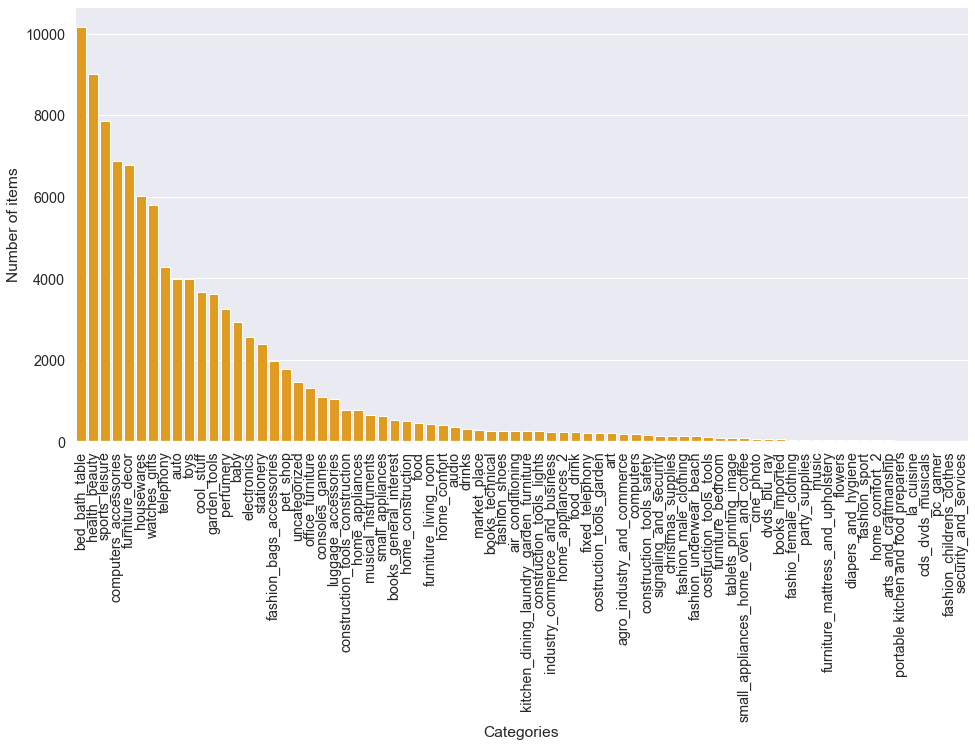

In [59]:
prod_cat = pd.DataFrame(main['product_category_name'])
prod_cat = prod_cat.groupby(['product_category_name']).size().reset_index(name='count')

prod_cat = prod_cat.sort_values(by=['count'], ascending=False)
f = plt.figure(figsize=(16, 8))
prod = sb.barplot(data =  prod_cat, x = 'product_category_name', y = 'count', color = 'orange', )
plt.xticks(rotation=90)
prod.set(xlabel = 'Categories', ylabel = 'Number of items')


### 6.2 Comparison of items ordered over the states. 

Average items bought:  3793.5185185185187


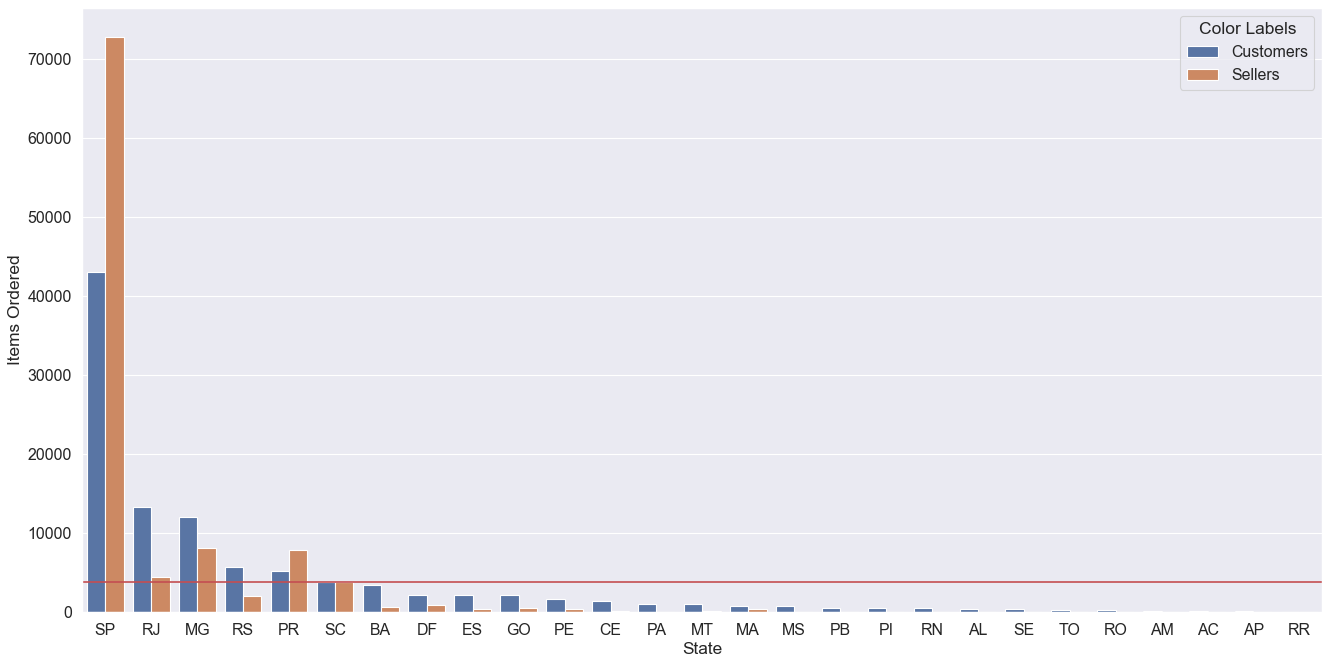

In [60]:
customer_state = pd.DataFrame(main['customer_state'])
customer_state = customer_state.groupby(['customer_state']).size().reset_index(name='customer_count')
customer_state = customer_state.sort_values(by=["customer_count"], ascending = False)
customer_state = customer_state.rename(columns = {'customer_state': 'state'}, inplace = False)
#print(customer_state)

seller_state = pd.DataFrame(main['seller_state'])
seller_state = seller_state.groupby(['seller_state']).size().reset_index(name='seller_count')
seller_state = seller_state.sort_values(by=["seller_count"], ascending = False)
seller_state = seller_state.rename(columns = {'seller_state': 'state',}, inplace = False)
#print(seller_state)

state_df = customer_state.merge(seller_state, how='left', 
                                         left_on='state', 
                                         right_on='state',)


state_df = state_df.fillna(0)
new_state_df = state_df
state_df = state_df.rename(columns={"customer_count": "Customers", "seller_count": "Sellers", "state":"State"})

#print(state_df)
state_df = pd.melt(state_df, id_vars = ["State"], value_vars = ["Customers", "Sellers"])
#state_df = state_df.sort_values(by=['value'], ascending=False)


total = len(new_state_df.index)
cust_total = new_state_df["customer_count"].sum()
avg = cust_total/total


state_df = state_df.rename(columns={"variable": "Color Labels", "value":"Items Ordered"})
plt.figure(figsize=(20,10), dpi = 80)
sb.barplot(data =  state_df, x = 'State', y = 'Items Ordered', hue = 'Color Labels')
plt.axhline(avg, color = 'r')
print("Average items bought: ", avg)

The average customer orders per state is marked out by the green line. We will use this as a minimum threshold. We will only be using data from the 5 states : SP, RJ, MG, RS, PR which have more customer orders than average for our data analysis to reduce noise.

In [61]:
MG = main.loc[main['customer_state']=='MG']
PR = main.loc[main['customer_state']=='PR']
RJ = main.loc[main['customer_state']=='RJ']
RS = main.loc[main['customer_state']=='RS']
SP = main.loc[main['customer_state']=='SP']

MGproduct = MG.reset_index().groupby('product_category_name').count()
MGproduct = MGproduct.sort_values('index', ascending = False)
MGproduct = MGproduct.drop(columns = ['customer_unique_id', 'customer_state','order_id','order_item_id','order_purchase_timestamp', 'product_id','seller_id','seller_state'])
MGproduct.rename(columns = {'index':'count'}, inplace=True)
MGproduct = MGproduct.reset_index()
MGproduct = MGproduct[:10]

PRproduct = PR.reset_index().groupby('product_category_name').count()
PRproduct = PRproduct.sort_values('index', ascending = False)
PRproduct = PRproduct.drop(columns = ['customer_unique_id', 'customer_state','order_id','order_item_id','order_purchase_timestamp', 'product_id','seller_id','seller_state'])
PRproduct.rename(columns = {'index':'count'}, inplace=True)
PRproduct = PRproduct.reset_index()
PRproduct = PRproduct[:10]

RJproduct = RJ.reset_index().groupby('product_category_name').count()
RJproduct = RJproduct.sort_values('index', ascending = False)
RJproduct = RJproduct.drop(columns = ['customer_unique_id', 'customer_state','order_id','order_item_id','order_purchase_timestamp', 'product_id','seller_id','seller_state'])
RJproduct.rename(columns = {'index':'count'}, inplace=True)
RJproduct = RJproduct.reset_index()
RJproduct = RJproduct[:10]


RSproduct = RS.reset_index().groupby('product_category_name').count()
RSproduct = RSproduct.sort_values('index', ascending = False)
RSproduct = RSproduct.drop(columns = ['customer_unique_id', 'customer_state','order_id','order_item_id','order_purchase_timestamp', 'product_id','seller_id','seller_state'])
RSproduct.rename(columns = {'index':'count'}, inplace=True)
RSproduct = RSproduct.reset_index()
RSproduct = RSproduct[:10]

SPproduct = SP.reset_index().groupby('product_category_name').count()
SPproduct = SPproduct.sort_values('index', ascending = False)
SPproduct = SPproduct.drop(columns = ['customer_unique_id', 'customer_state','order_id','order_item_id','order_purchase_timestamp', 'product_id','seller_id','seller_state'])
SPproduct.rename(columns = {'index':'count'}, inplace=True)
SPproduct = SPproduct.reset_index()
SPproduct = SPproduct[:10]




C:\Users\u2tra\anaconda3\envs\eqwe\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


### 6.3 Top 10 Categories of items purchased in the top 5 states.
We decided to use the top 10 categories instead of comparing all the items because we want to reduce noise created by smaller more random categories. From th

[Text(0.5, 0, 'Number of Items'),
 Text(0, 0.5, 'Categories'),
 Text(0.5, 1.0, 'State of Paraná')]

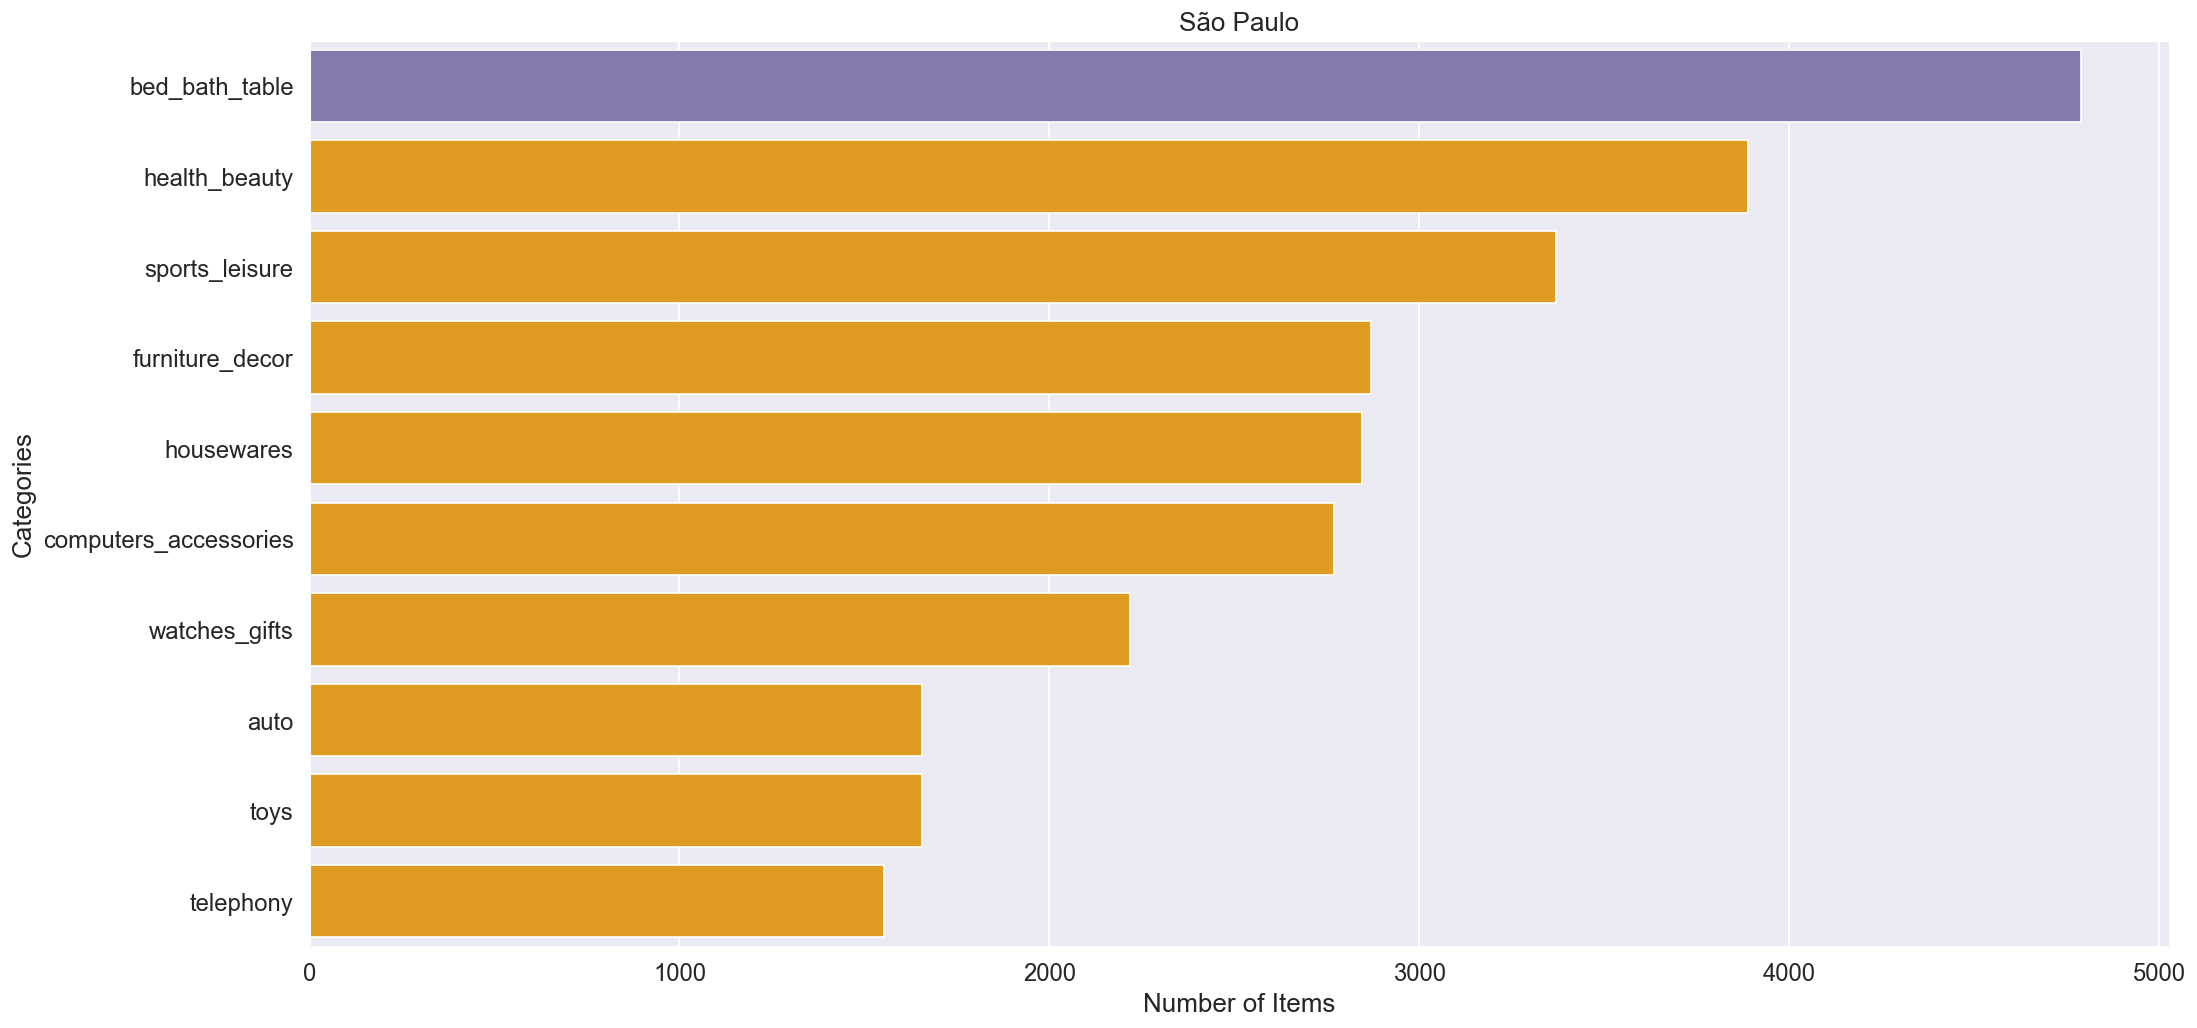

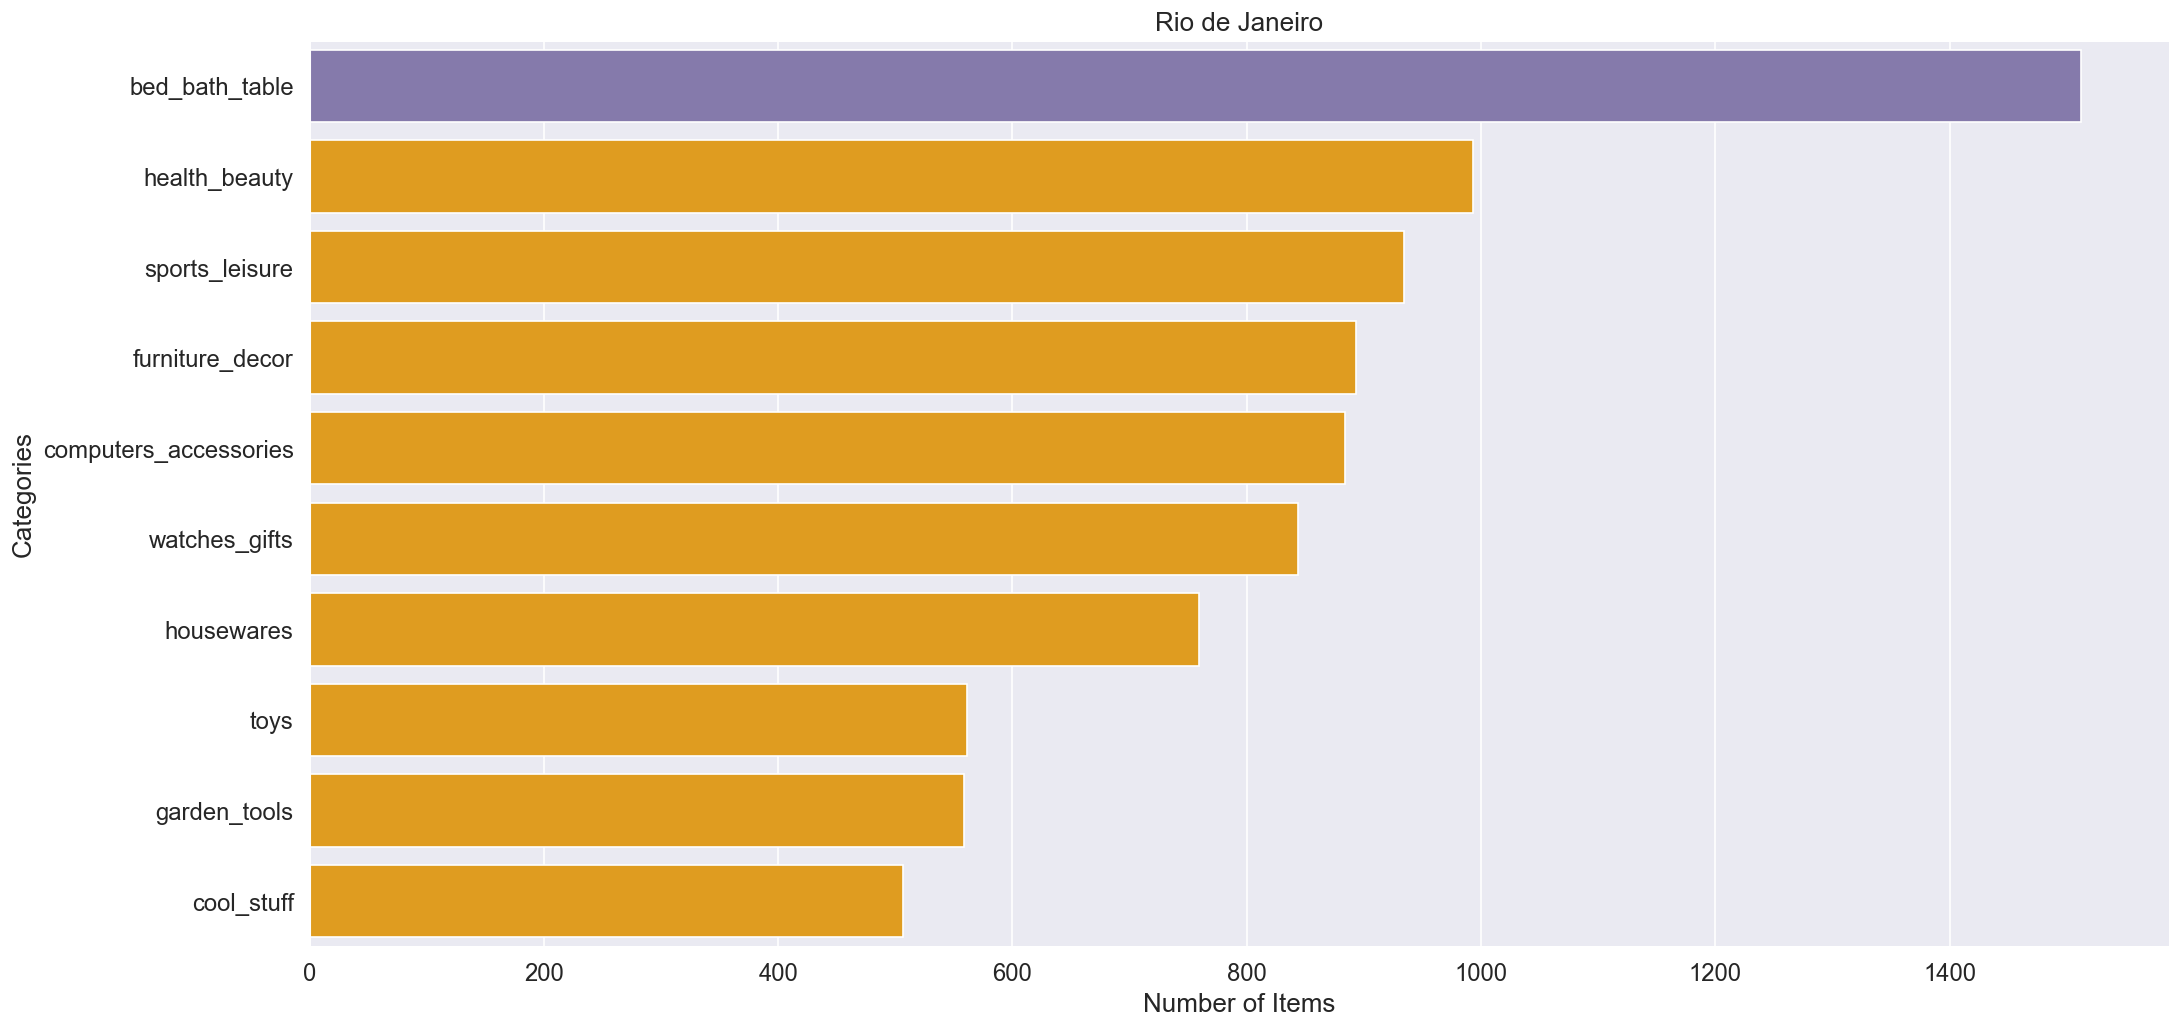

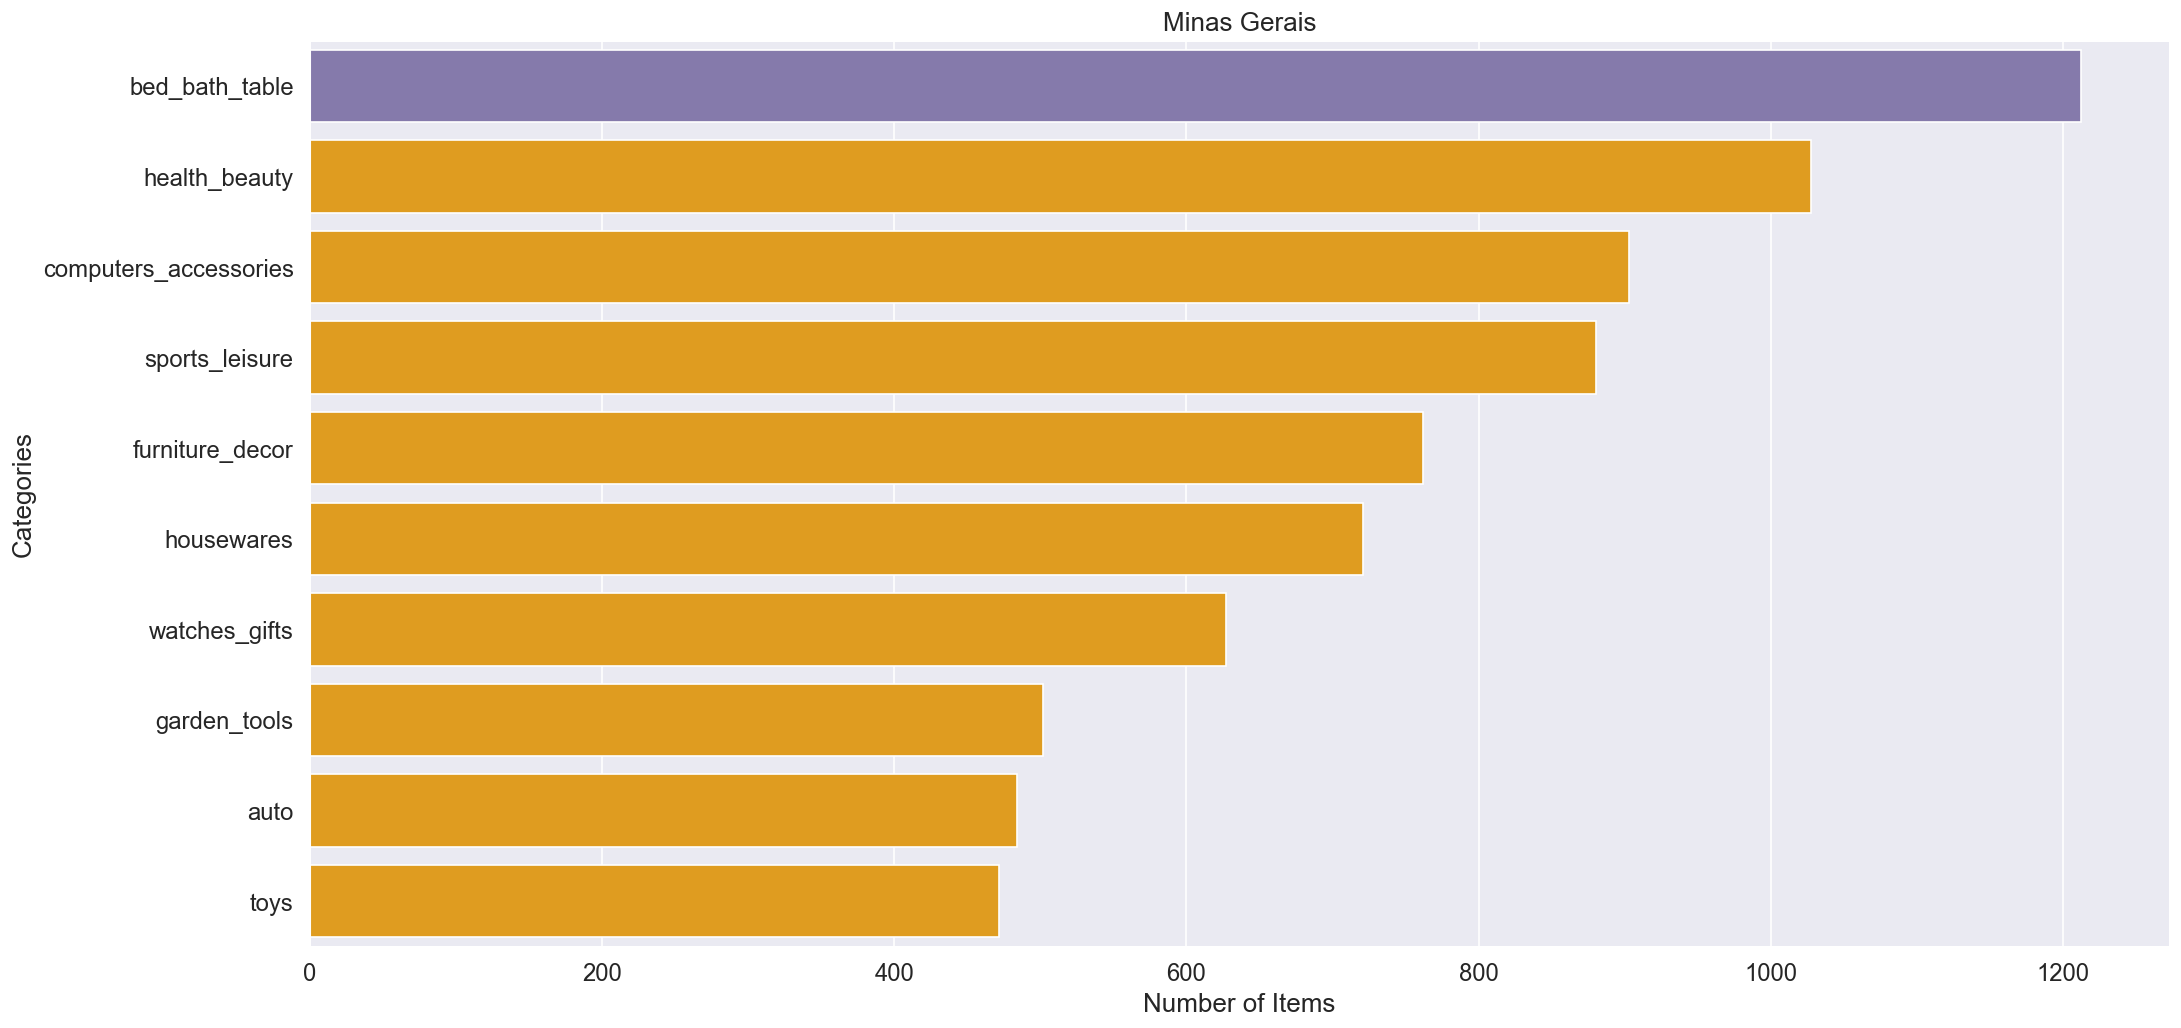

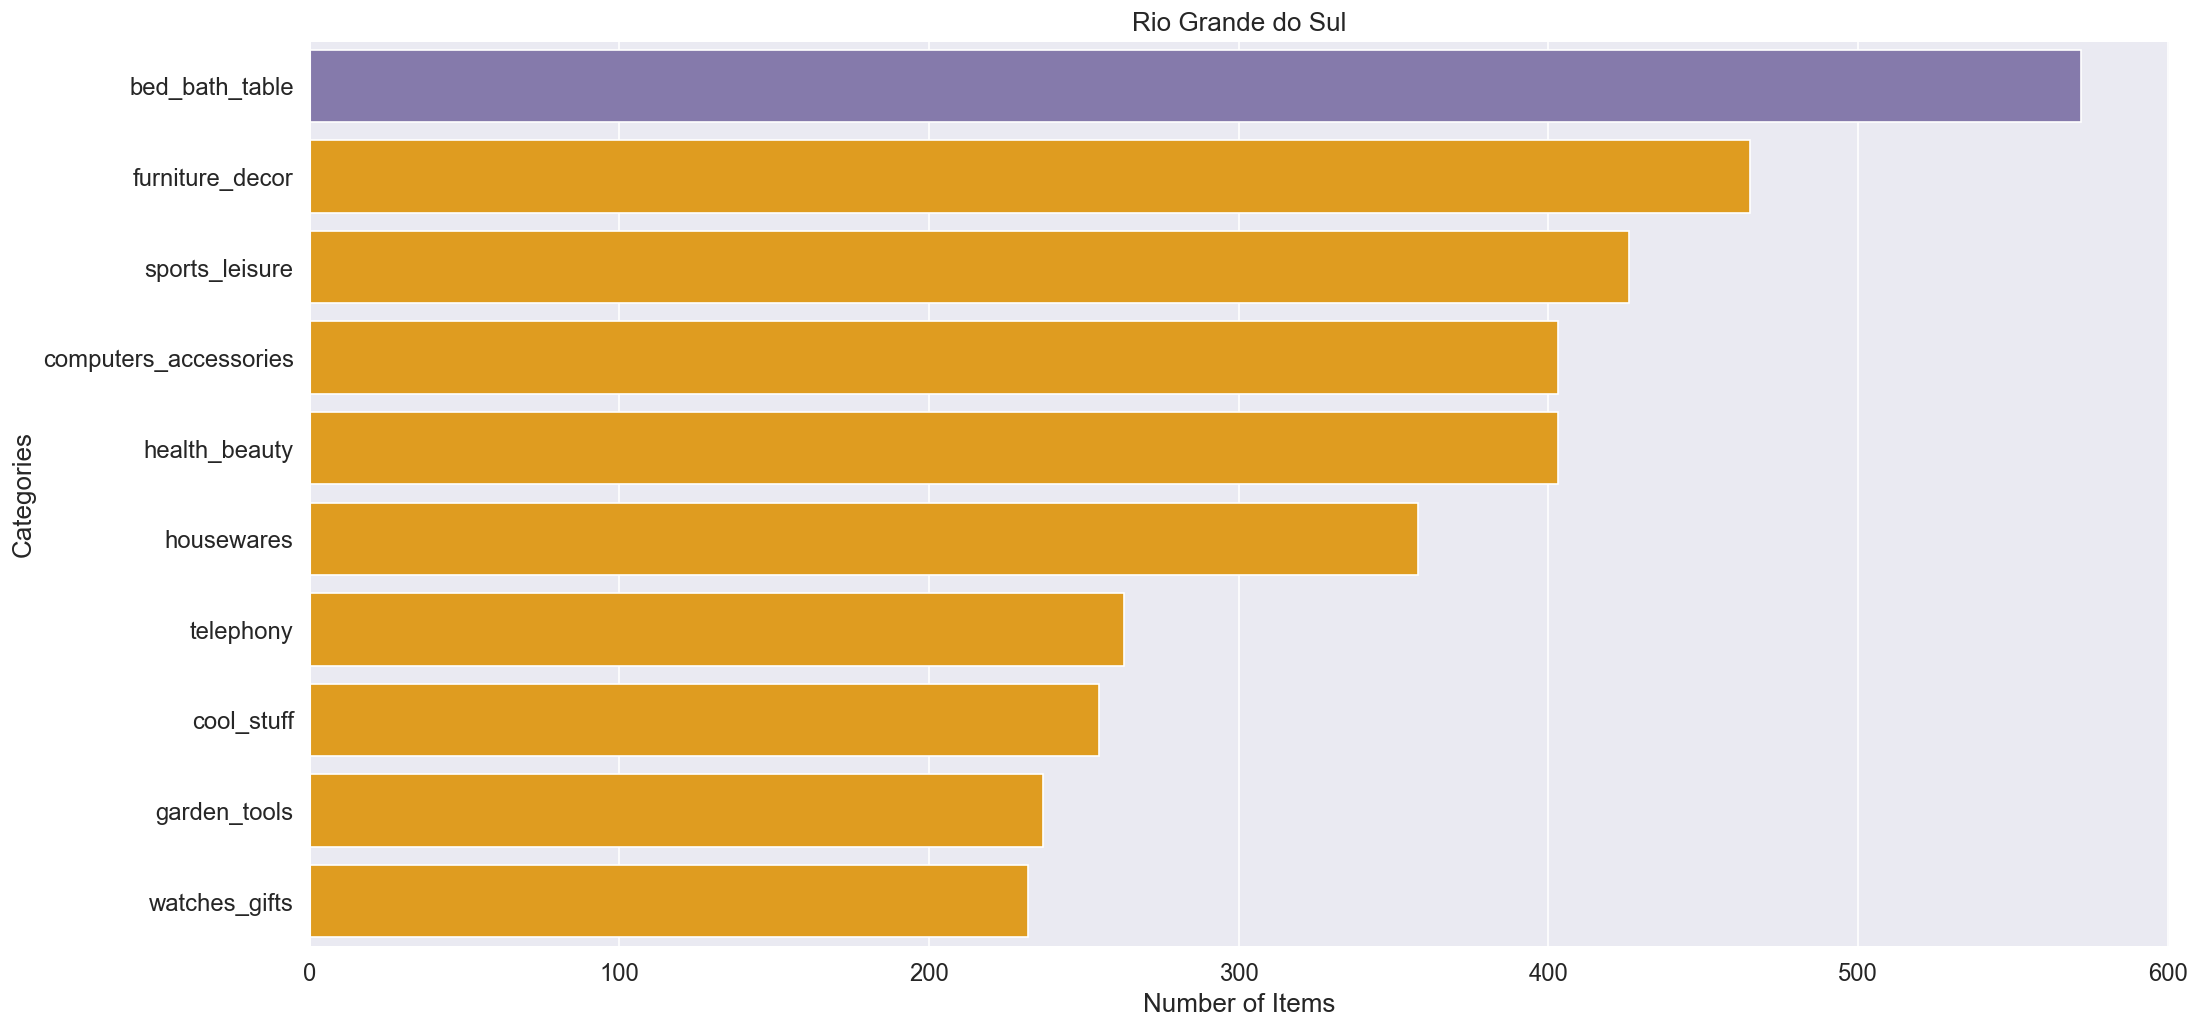

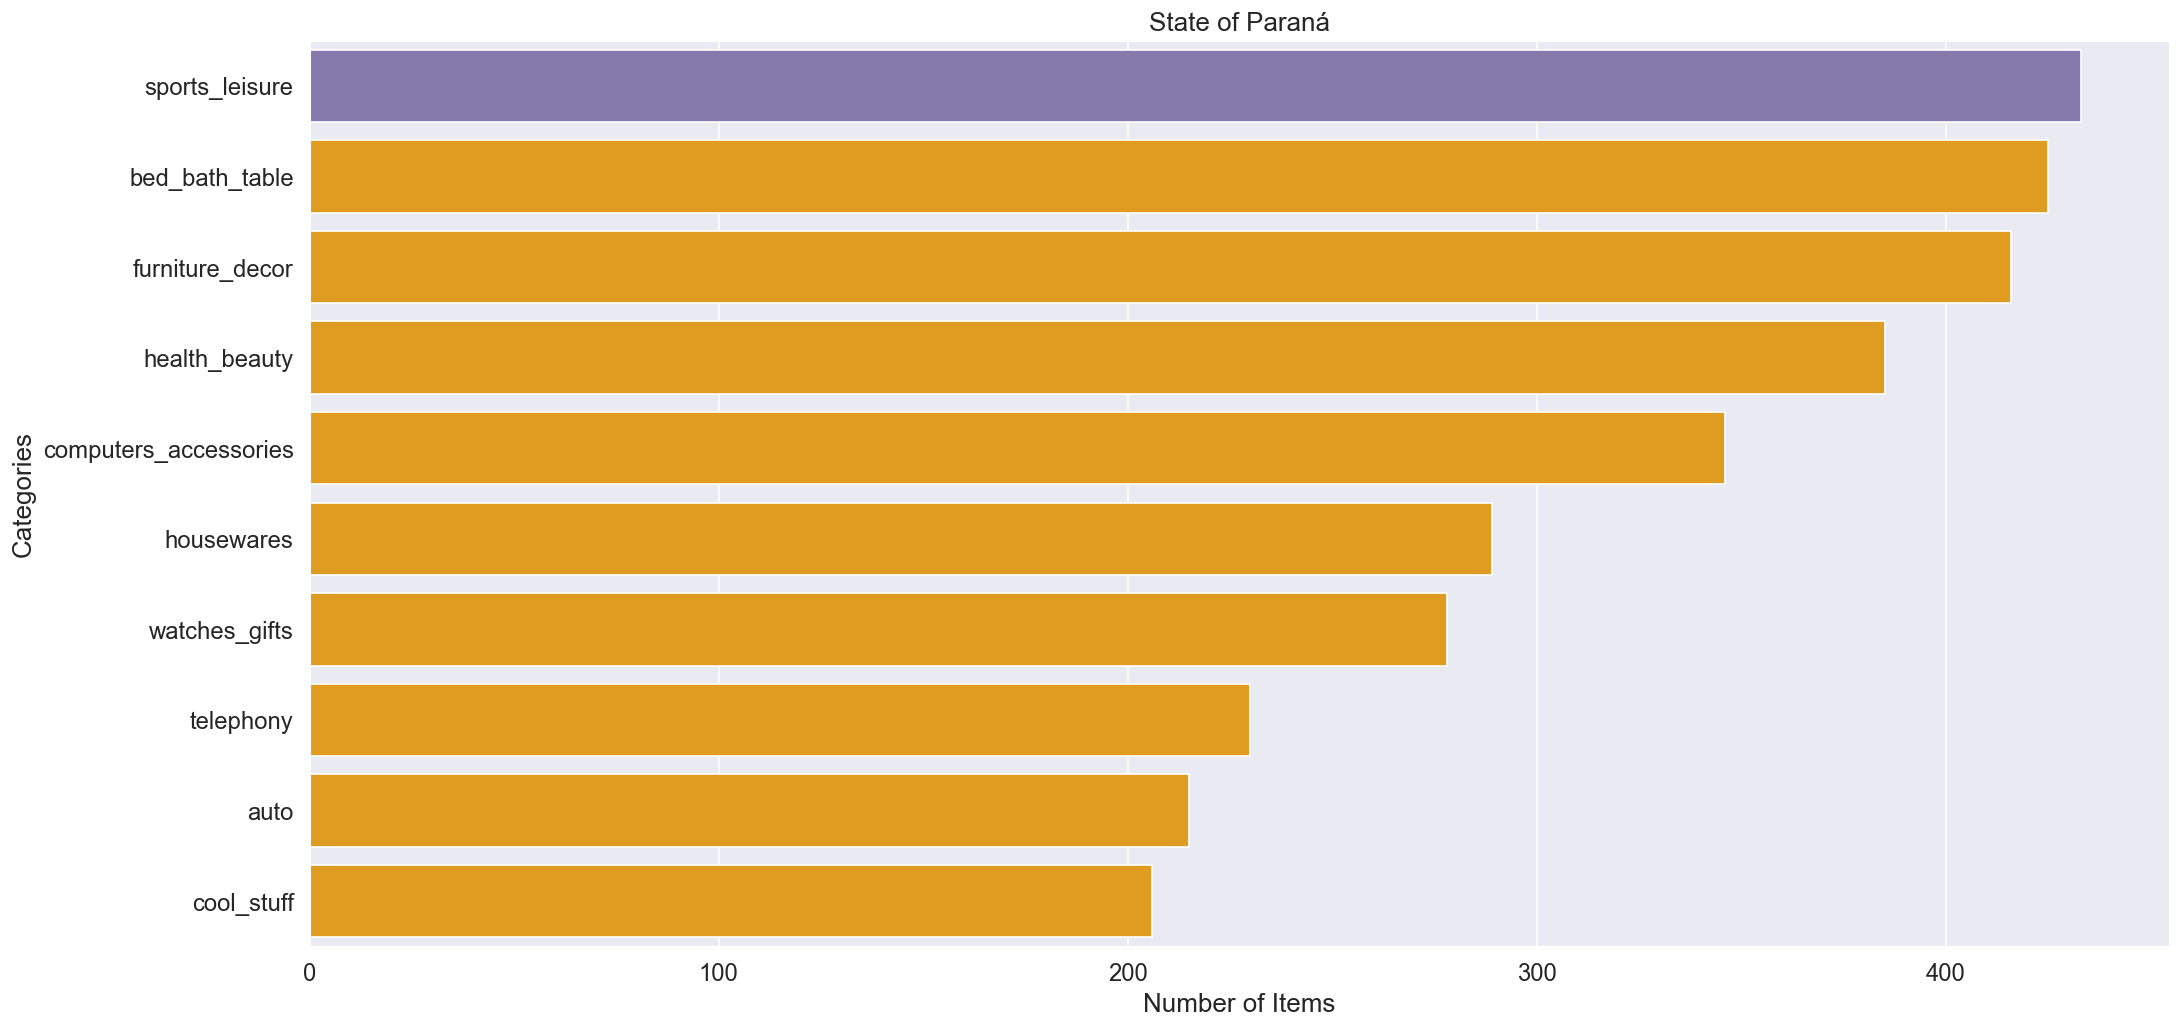

In [62]:
plt.figure(figsize=(20,10), dpi = 120)
clrs = ['orange' if (x < max(SPproduct['count'])) else 'm' for x in SPproduct['count']]
SP_g = sb.barplot(data =  SPproduct, y = 'product_category_name', x = 'count', palette = clrs, orient = 'h')
SP_g.set(xlabel = 'Number of Items', ylabel = 'Categories', title = 'São Paulo')

plt.figure(figsize=(20,10), dpi = 120)
clrs = ['orange' if (x < max(RJproduct['count'])) else 'm' for x in RJproduct['count']]
RJ_g = sb.barplot(data =  RJproduct, y = 'product_category_name', x = 'count', palette = clrs, orient = 'h')
RJ_g.set(xlabel = 'Number of Items', ylabel = 'Categories', title = 'Rio de Janeiro')

plt.figure(figsize=(20,10), dpi = 120)
clrs = ['orange' if (x < max(MGproduct['count'])) else 'm' for x in MGproduct['count']]
MG_g = sb.barplot(data =  MGproduct, y = 'product_category_name', x = 'count', palette = clrs, orient = 'h')
MG_g.set(xlabel = 'Number of Items', ylabel = 'Categories', title = 'Minas Gerais')


plt.figure(figsize=(20,10), dpi = 120)
clrs = ['orange' if (x < max(RSproduct['count'])) else 'm' for x in RSproduct['count']]
RS_g = sb.barplot(data =  RSproduct, y = 'product_category_name', x = 'count', palette = clrs, orient = 'h')
RS_g.set(xlabel = 'Number of Items', ylabel = 'Categories', title = 'Rio Grande do Sul')

plt.figure(figsize=(20,10), dpi = 120)
clrs = ['orange' if (x < max(PRproduct['count'])) else 'm' for x in PRproduct['count']]
PR_g = sb.barplot(data =  PRproduct, y = 'product_category_name', x = 'count', palette = clrs, orient = 'h')
PR_g.set(xlabel = 'Number of Items', ylabel = 'Categories', title = 'State of Paraná')



We can see that the top popular categories in each state are very similar, with bed_bath_table, health_beauty, furniture decor being the top few categories in each state. This could be because Brazilians place high emphasis on personal grooming and Brazilians bathe an average of 3 times a day, which causes high demand for toiletries which fall under bed_bath_table and beauty products.
We also notice that sports and leisure is the highest in Parana because it is home to a rainforest and wildlife and more locals are likely to participate in outdoor activities, hence the highest demand of products from the Sports_leisure categories

## 6.4 Timed based Observation of Rio De Janeiro:

Rio De Janeiro is used for time based data exploration because it is one of the more populated states in Brazil with high GDP compared to the rest of the states which indicates higher spending power and thus a significant sample size for time based exploration. Rio De Janeiro is also a cultural center of Brazil where many there are many festivities. We want to explore if such activities make an impact on the categories bought during the month.

We select the top 3 categories during each month to reduce noise in the heatmap data.

In [63]:

RJtime = RJ.reset_index().groupby(['product_category_name','order_purchase_timestamp']).count()
RJtime = RJtime.sort_values('index', ascending = False)
RJtime = RJtime.drop(columns = ['customer_unique_id', 'customer_state','order_id','order_item_id','product_id','seller_id','seller_state'])
RJtime.rename(columns = {'index':'count'}, inplace=True)
RJtime = RJtime.reset_index()
RJtime

RJtime['year'] = pd.DatetimeIndex(RJtime['order_purchase_timestamp']).year
RJtime['month'] = pd.DatetimeIndex(RJtime['order_purchase_timestamp']).month
RJtime = RJtime.drop(columns = 'order_purchase_timestamp')
RJtime

RJtime.isnull().sum() #ensure all rows are filled

RJtime = RJtime.groupby(["year","month"])
RJtime.first()

type(RJtime)

#convert to dataframe
RJtimetest = RJtime.apply(lambda x:x)
type(RJtimetest)

C:\Users\u2tra\anaconda3\envs\eqwe\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


pandas.core.frame.DataFrame

In [64]:
RJtimetest3 = RJtimetest.groupby(['product_category_name','year','month'])['count'].sum().reset_index()
RJtimetest3 = RJtimetest3.sort_values(by = ['year','month','count'], ascending = False)
RJtimetest3

twenty18 = RJtimetest3.loc[RJtimetest3['year']==2018]
twenty18 = twenty18.groupby('month').head(3)
twenty18

twenty17 = RJtimetest3.loc[RJtimetest3['year']==2017]
twenty17 = twenty17.groupby('month').head(3)
twenty17

frames = [twenty17, twenty18]
time = pd.concat(frames)
time.head(5)

,product_category_name,year,month,count
114,bed_bath_table,2017,12,90
897,toys,2017,12,75
831,sports_leisure,2017,12,59
113,bed_bath_table,2017,11,181
467,furniture_decor,2017,11,83


In [65]:
time['Date'] = pd.to_datetime(time[['year','month']].assign(DAY=1))
time.head()

,product_category_name,year,month,count,Date
114,bed_bath_table,2017,12,90,2017-12-01
897,toys,2017,12,75,2017-12-01
831,sports_leisure,2017,12,59,2017-12-01
113,bed_bath_table,2017,11,181,2017-11-01
467,furniture_decor,2017,11,83,2017-11-01


In [66]:
#pivot table
time1 = time.drop(columns=["year","month"])
time1

time2 = time1.pivot_table('count','Date','product_category_name')
time2

time3 = time2.fillna(0).astype(int)
time3_transpose = time3.transpose()
time3_transpose

Date,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01
product_category_name,,,,,,,,,,,,,,,,,,,,
bed_bath_table,9,25,41,38,40,48,79,70,77,96,181,90,108,82,108,90,73,88,91,77
computers_accessories,0,0,0,0,40,0,51,0,0,0,0,0,95,120,85,0,0,0,0,0
furniture_decor,19,38,41,23,0,0,0,51,48,52,83,0,0,0,0,0,0,0,0,0
garden_tools,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
health_beauty,0,18,30,0,0,34,0,39,58,0,0,0,0,79,0,0,89,80,68,73
housewares,0,0,0,0,41,34,0,0,0,0,0,0,0,0,0,0,0,0,0,77
sports_leisure,0,0,0,26,0,0,53,0,0,61,0,59,69,0,79,67,0,0,0,0
toys,0,0,0,0,0,0,0,0,0,0,79,75,0,0,0,0,0,0,0,0
watches_gifts,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72,100,79,69,0


We intend to find abnormalies in the data which can be shown in a heatmap of the time against the products bought
data with '0' means that the category was not in the top 3 during that period
We also used the first date of each month in the dates to represent the categories of items purchased during the whole month so that the timestamps can be formatted in "datetime"

<AxesSubplot:xlabel='Date', ylabel='product_category_name'>

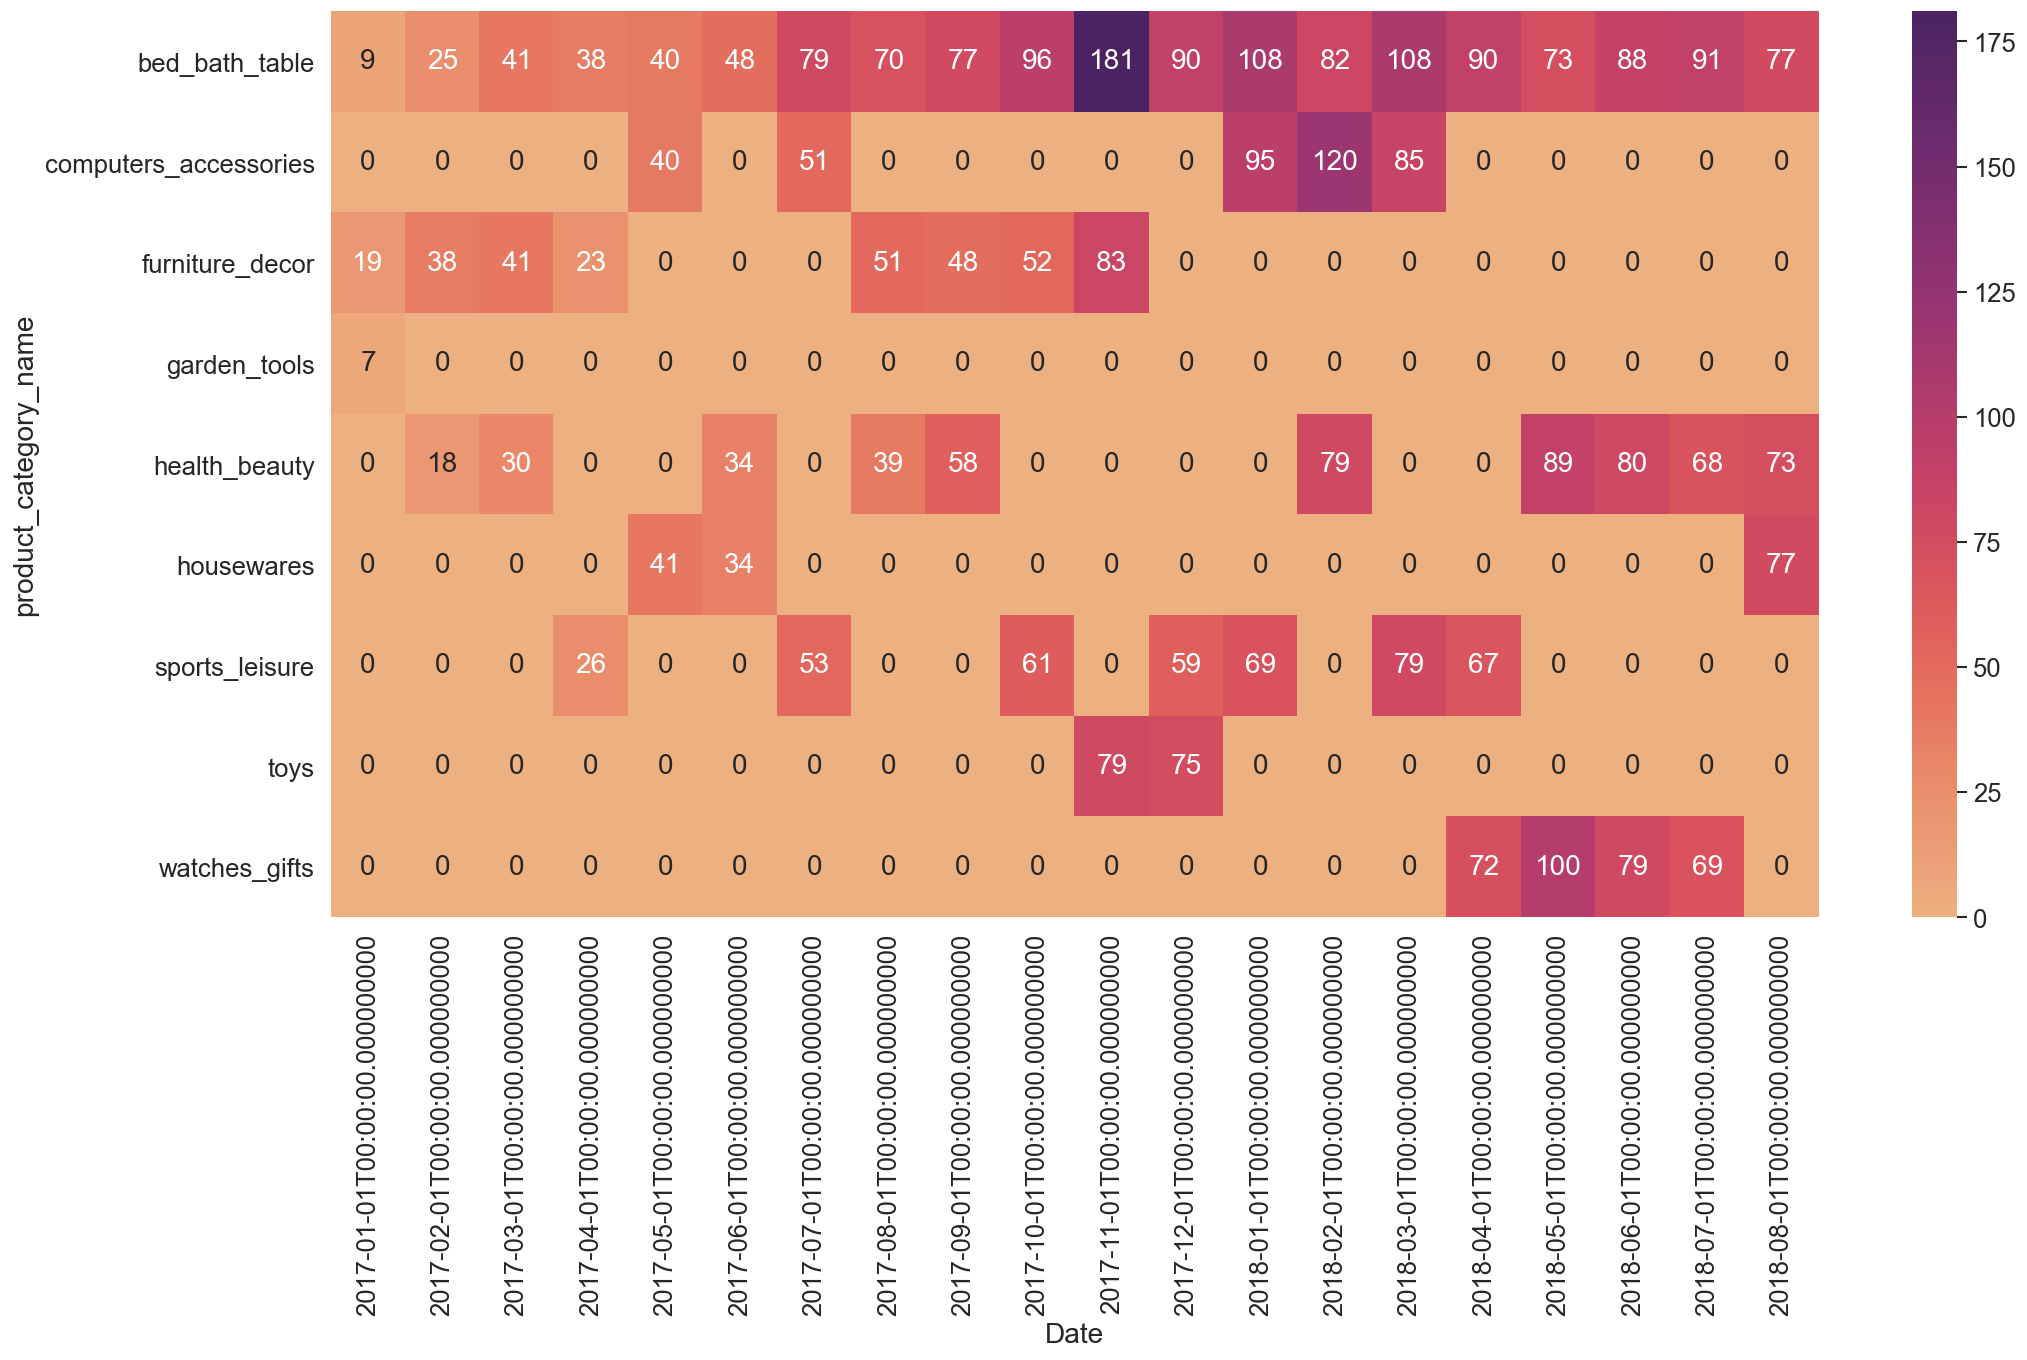

In [67]:
plt.figure(figsize=(20,10), dpi = 120)
sb.set(font_scale=1.4)
sb.heatmap(time3_transpose, vmin=0, vmax= 181, annot=True, fmt = 'd',cmap = 'flare')
#plt.xticks(rotation=90)

In the time based exploration of the top 3 categories in the more populated Rio, we observe an abnormality for bed bath table which was almost double normal value in nov 2017. This could be attributed to the yellow fever outbreak where people started buying more sanitary products, which fall under the ‘bed bathe table’ category.

We also notice a spike in toys during november and december probably due to christmas.
From August to September 2017, there was also a spike in furniture as it was the period of festive season which has increased the demand for furniture to support such events.


# 7. Association Rule Learning

## 7.1 Background

Association rules analysis is a technique to uncover how items are associated with each other, and is an important concept of machine learning being used in market basket analysis. 


In the Olist E-commerce site, products are organised in terms of categories: sports items are placed together, fashion, furniture, watches, etc are placed similarly to form individual sets of such groups. 
Investing time and resources on deliberate product placements like this not only reduces a customer’s shopping time, but also reminds the customer of what relevant items they might be interested in buying, thus helping Olist cross-sell across product categories in the process.


Association rules help uncover all such relationships between items from huge databases
Rules do not extract an individual’s preference, rather they find relationships between sets of elements of every distinct transaction. This is what makes them different from collaborative filtering, which is used in recommender systems

Due to the ambiguous nature of the datasets available with regard to product names, we will group the products according categories as these labels are readily available

## 7.2 Evaluation Measures

### Aim 
T
he aim of the model is to show the relations between product categories in the Olist dataset. For instance, if a customer buys from category X (antecedents), how likely will they buy from category Y (consequents).


### Input
The model takes in a binary table of order_id against product_category_name. This table shows what categories a particular order transaction contains. Each row in the table represents a “market basket” belonging to a unique order transaction


### Metrics
__Support:__ This says how popular an itemset is, it is number of times appear in total number of transaction. in other word we say frequency of item.


Shows how common a particular keyword is, as measured by the proportion (frequency of its occurrence as compared to other keywords)
If occurence of a specific keyword above a certain proportion is able to correlate to an incident, this proportion can be used as the support threshold
We can then associate other keywords with values above this support threshold as significant in the incident 
In many instances, you may want to look for high support in order to make sure it is a useful relationship. However, there may be instances where a low support is useful if you are trying to find “hidden” relationships.



support = occurance of item / total no of transaction.

__Confidence:__ This says how likely item Y is purchased when item X is purchased, expressed as {X -> Y}. This is measured by the proportion of transactions with item X, in which item Y also appears.


measure of the reliability of the rule
Indicates how likely Y occurs, given X occurs
A confidence of .5 in the above example would mean that in 50% of the cases where Diaper and Gum were purchased, the purchase also included Beer and Chips. For product recommendation, a 50% confidence may be perfectly acceptable but in a medical situation, this level may not be high enough



confidence = support ( X Union Y) / support(X).

__Lift:__ it is ratio of expected confidence to observed confidence. it is described as confidence of Y when item X was already known(x/y) to the confidence of Y when X item is unknown. in other words confidence of Y w.r.t. x and confidence of Y without X (means both are independent to each other). 1. rules with high lift -> occurs more freq than expected given the number of transaction and product combinations. 


Indicates how likely Y occurs, given X occurs, while controlling the frequency of Y
Lift is the ratio of the observed support to that expected if the two rules were independent 



lift = support (X Union Y)/ support(X) * support(Y) .

## 7.3 Generating Association Rules for order_id for the Entire Brazil

In [68]:
#convert data in format which it require converting using pivot table and Quantity sum as values. fill 0 if any nan values

basket = pd.pivot_table(data=main, index='order_id',columns='product_category_name', values= 'product_id', aggfunc='count', fill_value=0)
basket

C:\Users\u2tra\anaconda3\envs\eqwe\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


\
product_category_name            agro_industry_and_commerce air_conditioning   
order_id                                                                       
00010242fe8c5a6d1ba2dd792cb16214                          0                0   
00018f77f2f0320c557190d7a144bdd3                          0                0   
000229ec398224ef6ca0657da4fc703e                          0                0   
00024acbcdf0a6daa1e931b038114c75                          0                0   
00042b26cf59d7ce69dfabb4e55b4fd9                          0                0   
...                                                     ...              ...   
fffc94f6ce00a00581880bf54a75a037                          0                0   
fffcd46ef2263f404302a634eb57f7eb                          0                0   
fffce4705a9662cd70adb13d4a31832d                          0                0   
fffe18544ffabc95dfada21779c9644f                          0                0   
fffe41c64501cc87c801fd61db3f6244                          0                0   

                                                                            \
product_category_name            art arts_and_craftmanship audio auto baby   
order_id                                                                     
00010242fe8c5a6d1ba2dd792cb16214   0                     0     0    0    0   
00018f77f2f0320c557190d7a144bdd3   0                     0     0    0    0   
000229ec398224ef6ca0657da4fc703e   0                     0     0    0    0   
00024acbcdf0a6daa1e931b038114c75   0                     0     0    0    0   
00042b26cf59d7ce69dfabb4e55b4fd9   0                     0     0    0    0   
...                               ..                   ...   ...  ...  ...   
fffc94f6ce00a00581880bf54a75a037   0                     0     0    0    0   
fffcd46ef2263f404302a634eb57f7eb   0                     0     0    0    0   
fffce4705a9662cd70adb13d4a31832d   0                     0     0    0    0   
fffe18544ffabc95dfada21779c9644f   0                     0     0    0    0   
fffe41c64501cc87c801fd61db3f6244   0                     0     0    0    0   

                                                                        \
product_category_name            bed_bath_table books_general_interest   
order_id                                                                 
00010242fe8c5a6d1ba2dd792cb16214              0                      0   
00018f77f2f0320c557190d7a144bdd3              0                      0   
000229ec398224ef6ca0657da4fc703e              0                      0   
00024acbcdf0a6daa1e931b038114c75              0                      0   
00042b26cf59d7ce69dfabb4e55b4fd9              0                      0   
...                                         ...                    ...   
fffc94f6ce00a00581880bf54a75a037              0                      0   
fffcd46ef2263f404302a634eb57f7eb              0                      0   
fffce4705a9662cd70adb13d4a31832d              0                      0   
fffe18544ffabc95dfada21779c9644f              0                      0   
fffe41c64501cc87c801fd61db3f6244              1                      0   

                                                 ...                         \
product_category_name            books_imported  ... signaling_and_security   
order_id                                         ...                          
00010242fe8c5a6d1ba2dd792cb16214              0  ...                      0   
00018f77f2f0320c557190d7a144bdd3              0  ...                      0   
000229ec398224ef6ca0657da4fc703e              0  ...                      0   
00024acbcdf0a6daa1e931b038114c75              0  ...                      0   
00042b26cf59d7ce69dfabb4e55b4fd9              0  ...                      0   
...                                         ...  ...                    ...   
fffc94f6ce00a00581880bf54a75a037              0  ...                      0   
fffcd46ef2263f404302a634eb57f7eb     

In [69]:
# we dont need quantity sum we need either has taken or not so if user has taken that item mark as 1 else he has not taken 0.

def convert_into_binary(x):
    if x > 0:
        return 1
    else:
        return 0
    
basket_sets = basket.applymap(convert_into_binary)

In [70]:
basket_sets

\
product_category_name            agro_industry_and_commerce air_conditioning   
order_id                                                                       
00010242fe8c5a6d1ba2dd792cb16214                          0                0   
00018f77f2f0320c557190d7a144bdd3                          0                0   
000229ec398224ef6ca0657da4fc703e                          0                0   
00024acbcdf0a6daa1e931b038114c75                          0                0   
00042b26cf59d7ce69dfabb4e55b4fd9                          0                0   
...                                                     ...              ...   
fffc94f6ce00a00581880bf54a75a037                          0                0   
fffcd46ef2263f404302a634eb57f7eb                          0                0   
fffce4705a9662cd70adb13d4a31832d                          0                0   
fffe18544ffabc95dfada21779c9644f                          0                0   
fffe41c64501cc87c801fd61db3f6244                          0                0   

                                                                            \
product_category_name            art arts_and_craftmanship audio auto baby   
order_id                                                                     
00010242fe8c5a6d1ba2dd792cb16214   0                     0     0    0    0   
00018f77f2f0320c557190d7a144bdd3   0                     0     0    0    0   
000229ec398224ef6ca0657da4fc703e   0                     0     0    0    0   
00024acbcdf0a6daa1e931b038114c75   0                     0     0    0    0   
00042b26cf59d7ce69dfabb4e55b4fd9   0                     0     0    0    0   
...                               ..                   ...   ...  ...  ...   
fffc94f6ce00a00581880bf54a75a037   0                     0     0    0    0   
fffcd46ef2263f404302a634eb57f7eb   0                     0     0    0    0   
fffce4705a9662cd70adb13d4a31832d   0                     0     0    0    0   
fffe18544ffabc95dfada21779c9644f   0                     0     0    0    0   
fffe41c64501cc87c801fd61db3f6244   0                     0     0    0    0   

                                                                        \
product_category_name            bed_bath_table books_general_interest   
order_id                                                                 
00010242fe8c5a6d1ba2dd792cb16214              0                      0   
00018f77f2f0320c557190d7a144bdd3              0                      0   
000229ec398224ef6ca0657da4fc703e              0                      0   
00024acbcdf0a6daa1e931b038114c75              0                      0   
00042b26cf59d7ce69dfabb4e55b4fd9              0                      0   
...                                         ...                    ...   
fffc94f6ce00a00581880bf54a75a037              0                      0   
fffcd46ef2263f404302a634eb57f7eb              0                      0   
fffce4705a9662cd70adb13d4a31832d              0                      0   
fffe18544ffabc95dfada21779c9644f              0                      0   
fffe41c64501cc87c801fd61db3f6244              1                      0   

                                                 ...                         \
product_category_name            books_imported  ... signaling_and_security   
order_id                                         ...                          
00010242fe8c5a6d1ba2dd792cb16214              0  ...                      0   
00018f77f2f0320c557190d7a144bdd3              0  ...                      0   
000229ec398224ef6ca0657da4fc703e              0  ...                      0   
00024acbcdf0a6daa1e931b038114c75              0  ...                      0   
00042b26cf59d7ce69dfabb4e55b4fd9              0  ...                      0   
...                                         ...  ...                    ...   
fffc94f6ce00a00581880bf54a75a037              0  ...                      0   
fffcd46ef2263f404302a634eb57f7eb     

### Filter Rules Based on Minimum Support Threshold

Due to the sheer size of the dataset, we have decided on a minimum support threshold of 0.0001

In [71]:
#call apriori function and pass minimum support
frequent_itemsets = apriori(basket_sets, min_support=0.0001, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)
#it will generate frequent itemsets using two step approch
frequent_itemsets

,support,itemsets
7,0.095443,"((, bed_bath_table))"
42,0.089555,"((, health_beauty))"
64,0.078244,"((, sports_leisure))"
15,0.067794,"((, computers_accessories))"
38,0.065362,"((, furniture_decor))"
...,...,...
77,0.000111,"((, bed_bath_table), (, health_beauty))"
80,0.000111,"((, construction_tools_lights), (, furniture_d..."
84,0.000111,"((, housewares), (, garden_tools))"
87,0.000111,"((, housewares), (, sports_leisure))"


### Generate rules based on Lift Threshold

We have gathered that lift is the most effective metric for the rules to be evaluated upon, and decided on a minimum lift threshold of 0.01

In [72]:
# we have association rules which need to put on frequent itemset. here we are setting based on lift and has minimum lift as 1
rules_mlxtend = association_rules(frequent_itemsets, metric="lift", min_threshold=0.1)
rules_mlxtend = rules_mlxtend.sort_values('lift', ascending=False)
rules_mlxtend

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,"((, bed_bath_table))","((, home_confort))",0.095443,0.004024,0.000436,0.004566,1.134835,0.000052,1.000545
3,"((, home_confort))","((, bed_bath_table))",0.004024,0.095443,0.000436,0.108312,1.134835,0.000052,1.014432
12,"((, construction_tools_lights))","((, furniture_decor))",0.002473,0.065362,0.000111,0.045082,0.689728,-0.000050,0.978763
13,"((, furniture_decor))","((, construction_tools_lights))",0.065362,0.002473,0.000111,0.001706,0.689728,-0.000050,0.999231
10,"((, furniture_decor))","((, home_construction))",0.065362,0.004966,0.000132,0.002016,0.405903,-0.000193,0.997044
11,"((, home_construction))","((, furniture_decor))",0.004966,0.065362,0.000132,0.026531,0.405903,-0.000193,0.960110
4,"((, baby))","((, cool_stuff))",0.029240,0.036811,0.000203,0.006932,0.188324,-0.000874,0.969913
5,"((, cool_stuff))","((, baby))",0.036811,0.029240,0.000203,0.005507,0.188324,-0.000874,0.976135
6,"((, baby))","((, toys))",0.029240,0.039385,0.000193,0.006586,0.167214,-0.000959,0.966983
7,"((, toys))","((, baby))",0.039385,0.029240,0.000193,0.004889,0.167214,-0.000959,0.975530


In [73]:
# # Replace frozen sets with strings


# rules_mlxtend['antecedents'] = rules_mlxtend['antecedents'].apply(lambda a: ','.join(list(a)))
# rules_mlxtend['consequents'] = rules_mlxtend['consequents'].apply(lambda a: ','.join(list(a)))
# # Transform the DataFrame of rules into a matrix using the lift metric
# pivot = rules_mlxtend[rules_mlxtend['lhs items']>1].pivot(index = 'antecedents_', 
#                     columns = 'consequents_', values= 'lift')
# # Generate a heatmap with annotations on and the colorbar off
# sb.heatmap(pivot, annot = True)
# plt.yticks(rotation=0)
# plt.xticks(rotation=90)
# plt.show()

## 7.3 Generating Association Rules for order_id for Sao Paulo

In [74]:
#convert data in format which it require converting using pivot table and Quantity sum as values. fill 0 if any nan values

basket_SP = pd.pivot_table(data=SP, index='order_id',columns='product_category_name', values= 'product_id', aggfunc='count', fill_value=0)
basket_SP

C:\Users\u2tra\anaconda3\envs\eqwe\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


\
product_category_name            agro_industry_and_commerce air_conditioning   
order_id                                                                       
00018f77f2f0320c557190d7a144bdd3                          0                0   
00024acbcdf0a6daa1e931b038114c75                          0                0   
00042b26cf59d7ce69dfabb4e55b4fd9                          0                0   
00054e8431b9d7675808bcb819fb4a32                          0                0   
000576fe39319847cbb9d288c5617fa6                          0                0   
...                                                     ...              ...   
fff90cdcb3b2e6cfb397d05d562fd3fe                          0                0   
fffb0b1a50e65c449020434fa835e078                          0                0   
fffce4705a9662cd70adb13d4a31832d                          0                0   
fffe18544ffabc95dfada21779c9644f                          0                0   
fffe41c64501cc87c801fd61db3f6244                          0                0   

                                                                            \
product_category_name            art arts_and_craftmanship audio auto baby   
order_id                                                                     
00018f77f2f0320c557190d7a144bdd3   0                     0     0    0    0   
00024acbcdf0a6daa1e931b038114c75   0                     0     0    0    0   
00042b26cf59d7ce69dfabb4e55b4fd9   0                     0     0    0    0   
00054e8431b9d7675808bcb819fb4a32   0                     0     0    0    0   
000576fe39319847cbb9d288c5617fa6   0                     0     0    0    0   
...                               ..                   ...   ...  ...  ...   
fff90cdcb3b2e6cfb397d05d562fd3fe   0                     0     0    0    0   
fffb0b1a50e65c449020434fa835e078   0                     0     0    0    0   
fffce4705a9662cd70adb13d4a31832d   0                     0     0    0    0   
fffe18544ffabc95dfada21779c9644f   0                     0     0    0    0   
fffe41c64501cc87c801fd61db3f6244   0                     0     0    0    0   

                                                                        \
product_category_name            bed_bath_table books_general_interest   
order_id                                                                 
00018f77f2f0320c557190d7a144bdd3              0                      0   
00024acbcdf0a6daa1e931b038114c75              0                      0   
00042b26cf59d7ce69dfabb4e55b4fd9              0                      0   
00054e8431b9d7675808bcb819fb4a32              0                      0   
000576fe39319847cbb9d288c5617fa6              0                      0   
...                                         ...                    ...   
fff90cdcb3b2e6cfb397d05d562fd3fe              0                      0   
fffb0b1a50e65c449020434fa835e078              0                      0   
fffce4705a9662cd70adb13d4a31832d              0                      0   
fffe18544ffabc95dfada21779c9644f              0                      0   
fffe41c64501cc87c801fd61db3f6244              1                      0   

                                                 ...                         \
product_category_name            books_imported  ... signaling_and_security   
order_id                                         ...                          
00018f77f2f0320c557190d7a144bdd3              0  ...                      0   
00024acbcdf0a6daa1e931b038114c75              0  ...                      0   
00042b26cf59d7ce69dfabb4e55b4fd9              0  ...                      0   
00054e8431b9d7675808bcb819fb4a32              0  ...                      0   
000576fe39319847cbb9d288c5617fa6              0  ...                      0   
...                                         ...  ...                    ...   
fff90cdcb3b2e6cfb397d05d562fd3fe              0  ...                      0   
fffb0b1a50e65c449020434fa835e078     

In [75]:
# we dont need quantity sum we need either has taken or not so if user has taken that item mark as 1 else he has not taken 0.

def convert_into_binary(x):
    if x > 0:
        return 1
    else:
        return 0
    
basket_sets_SP = basket_SP.applymap(convert_into_binary)

basket_sets_SP

\
product_category_name            agro_industry_and_commerce air_conditioning   
order_id                                                                       
00018f77f2f0320c557190d7a144bdd3                          0                0   
00024acbcdf0a6daa1e931b038114c75                          0                0   
00042b26cf59d7ce69dfabb4e55b4fd9                          0                0   
00054e8431b9d7675808bcb819fb4a32                          0                0   
000576fe39319847cbb9d288c5617fa6                          0                0   
...                                                     ...              ...   
fff90cdcb3b2e6cfb397d05d562fd3fe                          0                0   
fffb0b1a50e65c449020434fa835e078                          0                0   
fffce4705a9662cd70adb13d4a31832d                          0                0   
fffe18544ffabc95dfada21779c9644f                          0                0   
fffe41c64501cc87c801fd61db3f6244                          0                0   

                                                                            \
product_category_name            art arts_and_craftmanship audio auto baby   
order_id                                                                     
00018f77f2f0320c557190d7a144bdd3   0                     0     0    0    0   
00024acbcdf0a6daa1e931b038114c75   0                     0     0    0    0   
00042b26cf59d7ce69dfabb4e55b4fd9   0                     0     0    0    0   
00054e8431b9d7675808bcb819fb4a32   0                     0     0    0    0   
000576fe39319847cbb9d288c5617fa6   0                     0     0    0    0   
...                               ..                   ...   ...  ...  ...   
fff90cdcb3b2e6cfb397d05d562fd3fe   0                     0     0    0    0   
fffb0b1a50e65c449020434fa835e078   0                     0     0    0    0   
fffce4705a9662cd70adb13d4a31832d   0                     0     0    0    0   
fffe18544ffabc95dfada21779c9644f   0                     0     0    0    0   
fffe41c64501cc87c801fd61db3f6244   0                     0     0    0    0   

                                                                        \
product_category_name            bed_bath_table books_general_interest   
order_id                                                                 
00018f77f2f0320c557190d7a144bdd3              0                      0   
00024acbcdf0a6daa1e931b038114c75              0                      0   
00042b26cf59d7ce69dfabb4e55b4fd9              0                      0   
00054e8431b9d7675808bcb819fb4a32              0                      0   
000576fe39319847cbb9d288c5617fa6              0                      0   
...                                         ...                    ...   
fff90cdcb3b2e6cfb397d05d562fd3fe              0                      0   
fffb0b1a50e65c449020434fa835e078              0                      0   
fffce4705a9662cd70adb13d4a31832d              0                      0   
fffe18544ffabc95dfada21779c9644f              0                      0   
fffe41c64501cc87c801fd61db3f6244              1                      0   

                                                 ...                         \
product_category_name            books_imported  ... signaling_and_security   
order_id                                         ...                          
00018f77f2f0320c557190d7a144bdd3              0  ...                      0   
00024acbcdf0a6daa1e931b038114c75              0  ...                      0   
00042b26cf59d7ce69dfabb4e55b4fd9              0  ...                      0   
00054e8431b9d7675808bcb819fb4a32              0  ...                      0   
000576fe39319847cbb9d288c5617fa6              0  ...                      0   
...                                         ...  ...                    ...   
fff90cdcb3b2e6cfb397d05d562fd3fe              0  ...                      0   
fffb0b1a50e65c449020434fa835e078     

In [76]:
#call apriori function and pass minimum support
frequent_itemsets_SP = apriori(basket_sets_SP, min_support=0.0001, use_colnames=True)
frequent_itemsets_SP = frequent_itemsets_SP.sort_values('support', ascending=False)
#it will generate frequent itemsets using two step approch
frequent_itemsets_SP

,support,itemsets
7,0.106731,"((, bed_bath_table))"
42,0.091577,"((, health_beauty))"
64,0.079662,"((, sports_leisure))"
48,0.067215,"((, housewares))"
38,0.065837,"((, furniture_decor))"
...,...,...
11,0.000145,"((, cds_dvds_musicals))"
72,0.000145,"((, baby), (, cool_stuff))"
71,0.000121,"((, baby), (, bed_bath_table))"
81,0.000121,"((, perfumery), (, health_beauty))"


In [77]:
# we have association rules which need to put on frequent itemset. here we are setting based on lift and has minimum lift as 1
rules_mlxtend_SP = association_rules(frequent_itemsets_SP, metric="lift", min_threshold=0.1)
rules_mlxtend_SP = rules_mlxtend_SP.sort_values('lift', ascending=False)
rules_mlxtend_SP

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"((, bed_bath_table))","((, home_confort))",0.106731,0.004447,0.000411,0.003850,0.865645,-0.000064,0.999400
1,"((, home_confort))","((, bed_bath_table))",0.004447,0.106731,0.000411,0.092391,0.865645,-0.000064,0.984200
7,"((, home_construction))","((, furniture_decor))",0.004931,0.065837,0.000145,0.029412,0.446737,-0.000180,0.962471
6,"((, furniture_decor))","((, home_construction))",0.065837,0.004931,0.000145,0.002203,0.446737,-0.000180,0.997266
2,"((, baby))","((, toys))",0.028616,0.038961,0.000242,0.008446,0.216781,-0.000873,0.969225
3,"((, toys))","((, baby))",0.038961,0.028616,0.000242,0.006203,0.216781,-0.000873,0.977447
5,"((, housewares))","((, uncategorized))",0.067215,0.014236,0.000193,0.002877,0.202075,-0.000763,0.988608
4,"((, uncategorized))","((, housewares))",0.014236,0.067215,0.000193,0.013582,0.202075,-0.000763,0.945629
8,"((, baby))","((, cool_stuff))",0.028616,0.031758,0.000145,0.005068,0.159567,-0.000764,0.973173
9,"((, cool_stuff))","((, baby))",0.031758,0.028616,0.000145,0.004566,0.159567,-0.000764,0.975840


In [78]:

# # Replace frozen sets with strings
# rules_mlxtend_SP['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
# rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))
# # Transform the DataFrame of rules into a matrix using the lift metric
# pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
#                     columns = 'consequents_', values= 'lift')
# # Generate a heatmap with annotations on and the colorbar off
# sns.heatmap(pivot, annot = True)
# plt.yticks(rotation=0)
# plt.xticks(rotation=90)
# plt.show()

## 7.4 Generating Association Rules for order_id for Minas Gerais

In [79]:
#convert data in format which it require converting using pivot table and Quantity sum as values. fill 0 if any nan values

basket_MG = pd.pivot_table(data=MG, index='order_id',columns='product_category_name', values= 'product_id', aggfunc='count', fill_value=0)
basket_MG

C:\Users\u2tra\anaconda3\envs\eqwe\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


\
product_category_name            agro_industry_and_commerce air_conditioning   
order_id                                                                       
000229ec398224ef6ca0657da4fc703e                          0                0   
00048cc3ae777c65dbb7d2a0634bc1ea                          0                0   
0009792311464db532ff765bf7b182ae                          0                0   
001427c0ec99cf8af737bd88e92fd444                          0                0   
0019c29108428acffd089c36103c9440                          0                0   
...                                                     ...              ...   
ffe4972089425f7752aad086a7fdce28                          0                0   
ffea406a848c8afe4dec22bf6290ba00                          0                0   
fff3983dfa3c5a0d752d8d17baa406a0                          0                0   
fff8286f77788ab8b55b2e5747fa7dd8                          0                0   
fffbee3b5462987e66fb49b1c5411df2                          0                0   

                                                                            \
product_category_name            art arts_and_craftmanship audio auto baby   
order_id                                                                     
000229ec398224ef6ca0657da4fc703e   0                     0     0    0    0   
00048cc3ae777c65dbb7d2a0634bc1ea   0                     0     0    0    0   
0009792311464db532ff765bf7b182ae   0                     0     0    0    0   
001427c0ec99cf8af737bd88e92fd444   0                     0     0    0    0   
0019c29108428acffd089c36103c9440   0                     0     0    0    0   
...                               ..                   ...   ...  ...  ...   
ffe4972089425f7752aad086a7fdce28   0                     0     0    0    0   
ffea406a848c8afe4dec22bf6290ba00   0                     0     0    0    0   
fff3983dfa3c5a0d752d8d17baa406a0   0                     0     0    0    0   
fff8286f77788ab8b55b2e5747fa7dd8   0                     0     0    0    0   
fffbee3b5462987e66fb49b1c5411df2   0                     0     0    0    0   

                                                                        \
product_category_name            bed_bath_table books_general_interest   
order_id                                                                 
000229ec398224ef6ca0657da4fc703e              0                      0   
00048cc3ae777c65dbb7d2a0634bc1ea              0                      0   
0009792311464db532ff765bf7b182ae              0                      0   
001427c0ec99cf8af737bd88e92fd444              0                      0   
0019c29108428acffd089c36103c9440              0                      0   
...                                         ...                    ...   
ffe4972089425f7752aad086a7fdce28              0                      0   
ffea406a848c8afe4dec22bf6290ba00              0                      0   
fff3983dfa3c5a0d752d8d17baa406a0              0                      0   
fff8286f77788ab8b55b2e5747fa7dd8              0                      0   
fffbee3b5462987e66fb49b1c5411df2              0                      0   

                                                 ...                         \
product_category_name            books_imported  ... signaling_and_security   
order_id                                         ...                          
000229ec398224ef6ca0657da4fc703e              0  ...                      0   
00048cc3ae777c65dbb7d2a0634bc1ea              0  ...                      0   
0009792311464db532ff765bf7b182ae              0  ...                      0   
001427c0ec99cf8af737bd88e92fd444              0  ...                      0   
0019c29108428acffd089c36103c9440              0  ...                      0   
...                                         ...  ...                    ...   
ffe4972089425f7752aad086a7fdce28              0  ...                      0   
ffea406a848c8afe4dec22bf6290ba00     

In [80]:
# we dont need quantity sum we need either has taken or not so if user has taken that item mark as 1 else he has not taken 0.

def convert_into_binary(x):
    if x > 0:
        return 1
    else:
        return 0
    
basket_sets_MG = basket_MG.applymap(convert_into_binary)

basket_sets_MG

\
product_category_name            agro_industry_and_commerce air_conditioning   
order_id                                                                       
000229ec398224ef6ca0657da4fc703e                          0                0   
00048cc3ae777c65dbb7d2a0634bc1ea                          0                0   
0009792311464db532ff765bf7b182ae                          0                0   
001427c0ec99cf8af737bd88e92fd444                          0                0   
0019c29108428acffd089c36103c9440                          0                0   
...                                                     ...              ...   
ffe4972089425f7752aad086a7fdce28                          0                0   
ffea406a848c8afe4dec22bf6290ba00                          0                0   
fff3983dfa3c5a0d752d8d17baa406a0                          0                0   
fff8286f77788ab8b55b2e5747fa7dd8                          0                0   
fffbee3b5462987e66fb49b1c5411df2                          0                0   

                                                                            \
product_category_name            art arts_and_craftmanship audio auto baby   
order_id                                                                     
000229ec398224ef6ca0657da4fc703e   0                     0     0    0    0   
00048cc3ae777c65dbb7d2a0634bc1ea   0                     0     0    0    0   
0009792311464db532ff765bf7b182ae   0                     0     0    0    0   
001427c0ec99cf8af737bd88e92fd444   0                     0     0    0    0   
0019c29108428acffd089c36103c9440   0                     0     0    0    0   
...                               ..                   ...   ...  ...  ...   
ffe4972089425f7752aad086a7fdce28   0                     0     0    0    0   
ffea406a848c8afe4dec22bf6290ba00   0                     0     0    0    0   
fff3983dfa3c5a0d752d8d17baa406a0   0                     0     0    0    0   
fff8286f77788ab8b55b2e5747fa7dd8   0                     0     0    0    0   
fffbee3b5462987e66fb49b1c5411df2   0                     0     0    0    0   

                                                                        \
product_category_name            bed_bath_table books_general_interest   
order_id                                                                 
000229ec398224ef6ca0657da4fc703e              0                      0   
00048cc3ae777c65dbb7d2a0634bc1ea              0                      0   
0009792311464db532ff765bf7b182ae              0                      0   
001427c0ec99cf8af737bd88e92fd444              0                      0   
0019c29108428acffd089c36103c9440              0                      0   
...                                         ...                    ...   
ffe4972089425f7752aad086a7fdce28              0                      0   
ffea406a848c8afe4dec22bf6290ba00              0                      0   
fff3983dfa3c5a0d752d8d17baa406a0              0                      0   
fff8286f77788ab8b55b2e5747fa7dd8              0                      0   
fffbee3b5462987e66fb49b1c5411df2              0                      0   

                                                 ...                         \
product_category_name            books_imported  ... signaling_and_security   
order_id                                         ...                          
000229ec398224ef6ca0657da4fc703e              0  ...                      0   
00048cc3ae777c65dbb7d2a0634bc1ea              0  ...                      0   
0009792311464db532ff765bf7b182ae              0  ...                      0   
001427c0ec99cf8af737bd88e92fd444              0  ...                      0   
0019c29108428acffd089c36103c9440              0  ...                      0   
...                                         ...  ...                    ...   
ffe4972089425f7752aad086a7fdce28              0  ...                      0   
ffea406a848c8afe4dec22bf6290ba00     

In [81]:
#call apriori function and pass minimum support
frequent_itemsets_MG = apriori(basket_sets_MG, min_support=0.0001, use_colnames=True)
frequent_itemsets_MG = frequent_itemsets_MG.sort_values('support', ascending=False)
#it will generate frequent itemsets using two step approch
frequent_itemsets_MG

,support,itemsets
7,0.097800,"((, bed_bath_table))"
40,0.087578,"((, health_beauty))"
14,0.075970,"((, computers_accessories))"
62,0.075104,"((, sports_leisure))"
36,0.062976,"((, furniture_decor))"
...,...,...
81,0.000173,"((, watches_gifts), (, furniture_decor))"
83,0.000173,"((, sports_leisure), (, garden_tools))"
84,0.000173,"((, housewares), (, sports_leisure))"
29,0.000173,"((, fashion_sport))"


In [82]:
# we have association rules which need to put on frequent itemset. here we are setting based on lift and has minimum lift as 1
rules_mlxtend_MG = association_rules(frequent_itemsets_MG, metric="lift", min_threshold=0.1)
rules_mlxtend_MG = rules_mlxtend_MG.sort_values('lift', ascending=False)
rules_mlxtend_MG

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,"((, bed_bath_table))","((, home_confort))",0.097800,0.004591,0.000433,0.004429,0.964621,-0.000016,0.999837
3,"((, home_confort))","((, bed_bath_table))",0.004591,0.097800,0.000433,0.094340,0.964621,-0.000016,0.996179
12,"((, construction_tools_lights))","((, furniture_decor))",0.003119,0.062976,0.000173,0.055556,0.882164,-0.000023,0.992143
13,"((, furniture_decor))","((, construction_tools_lights))",0.062976,0.003119,0.000173,0.002751,0.882164,-0.000023,0.999632
14,"((, home_construction))","((, furniture_decor))",0.005024,0.062976,0.000173,0.034483,0.547550,-0.000143,0.970489
15,"((, furniture_decor))","((, home_construction))",0.062976,0.005024,0.000173,0.002751,0.547550,-0.000143,0.997721
16,"((, luggage_accessories))","((, stationery))",0.015246,0.021050,0.000173,0.011364,0.539843,-0.000148,0.990202
17,"((, stationery))","((, luggage_accessories))",0.021050,0.015246,0.000173,0.008230,0.539843,-0.000148,0.992926
4,"((, uncategorized))","((, housewares))",0.014900,0.060811,0.000347,0.023256,0.382429,-0.000560,0.961551
5,"((, housewares))","((, uncategorized))",0.060811,0.014900,0.000347,0.005698,0.382429,-0.000560,0.990746


## 7.5 Generating Association Rules for order_id for Rio de Janeiro

In [83]:
#convert data in format which it require converting using pivot table and Quantity sum as values. fill 0 if any nan values

basket_RJ = pd.pivot_table(data=RJ, index='order_id',columns='product_category_name', values= 'product_id', aggfunc='count', fill_value=0)
basket_RJ

C:\Users\u2tra\anaconda3\envs\eqwe\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


\
product_category_name            agro_industry_and_commerce air_conditioning   
order_id                                                                       
00010242fe8c5a6d1ba2dd792cb16214                          0                0   
0006ec9db01a64e59a68b2c340bf65a7                          0                0   
000f25f4d72195062c040b12dce9a18a                          0                0   
0010b2e5201cc5f1ae7e9c6cc8f5bd00                          0                0   
00119ff934e539cf26f92b9ef0cdfed8                          0                0   
...                                                     ...              ...   
ffef9e1de5dd07b397b373f9bb72cccf                          0                0   
fff2e9e3aa8644e19710216b4ef53ab2                          0                0   
fff6889749958e42b47a7977a4cf0ea0                          0                0   
fff7c4452f050315db1b3f24d9df5fcd                          0                0   
fffb2ef8874127f75b52b643880fd7e0                          0                0   

                                                                     \
product_category_name            art audio auto baby bed_bath_table   
order_id                                                              
00010242fe8c5a6d1ba2dd792cb16214   0     0    0    0              0   
0006ec9db01a64e59a68b2c340bf65a7   0     0    0    0              1   
000f25f4d72195062c040b12dce9a18a   0     0    0    0              0   
0010b2e5201cc5f1ae7e9c6cc8f5bd00   0     0    0    0              0   
00119ff934e539cf26f92b9ef0cdfed8   0     0    0    0              0   
...                               ..   ...  ...  ...            ...   
ffef9e1de5dd07b397b373f9bb72cccf   0     0    0    0              0   
fff2e9e3aa8644e19710216b4ef53ab2   0     0    0    0              1   
fff6889749958e42b47a7977a4cf0ea0   0     0    0    0              0   
fff7c4452f050315db1b3f24d9df5fcd   0     0    0    0              0   
fffb2ef8874127f75b52b643880fd7e0   0     0    0    0              1   

                                                                        \
product_category_name            books_general_interest books_imported   
order_id                                                                 
00010242fe8c5a6d1ba2dd792cb16214                      0              0   
0006ec9db01a64e59a68b2c340bf65a7                      0              0   
000f25f4d72195062c040b12dce9a18a                      0              0   
0010b2e5201cc5f1ae7e9c6cc8f5bd00                      0              0   
00119ff934e539cf26f92b9ef0cdfed8                      0              0   
...                                                 ...            ...   
ffef9e1de5dd07b397b373f9bb72cccf                      0              0   
fff2e9e3aa8644e19710216b4ef53ab2                      0              0   
fff6889749958e42b47a7977a4cf0ea0                      0              0   
fff7c4452f050315db1b3f24d9df5fcd                      0              0   
fffb2ef8874127f75b52b643880fd7e0                      0              0   

                                                  ...                         \
product_category_name            books_technical  ... signaling_and_security   
order_id                                          ...                          
00010242fe8c5a6d1ba2dd792cb16214               0  ...                      0   
0006ec9db01a64e59a68b2c340bf65a7               0  ...                      0   
000f25f4d72195062c040b12dce9a18a               0  ...                      0   
0010b2e5201cc5f1ae7e9c6cc8f5bd00               0  ...                      0   
00119ff934e539cf26f92b9ef0cdfed8               0  ...                      0   
...                                          ...  ...                    ...   
ffef9e1de5dd07b397b373f9bb72cccf               0  ...                      0   
fff2e9e3aa8644e19710216b4ef53ab2               0  ...                      0   
fff6889749958e42b47a7977a4cf0ea0             

In [84]:
# we dont need quantity sum we need either has taken or not so if user has taken that item mark as 1 else he has not taken 0.

def convert_into_binary(x):
    if x > 0:
        return 1
    else:
        return 0
    
basket_sets_RJ = basket_RJ.applymap(convert_into_binary)

basket_sets_RJ

\
product_category_name            agro_industry_and_commerce air_conditioning   
order_id                                                                       
00010242fe8c5a6d1ba2dd792cb16214                          0                0   
0006ec9db01a64e59a68b2c340bf65a7                          0                0   
000f25f4d72195062c040b12dce9a18a                          0                0   
0010b2e5201cc5f1ae7e9c6cc8f5bd00                          0                0   
00119ff934e539cf26f92b9ef0cdfed8                          0                0   
...                                                     ...              ...   
ffef9e1de5dd07b397b373f9bb72cccf                          0                0   
fff2e9e3aa8644e19710216b4ef53ab2                          0                0   
fff6889749958e42b47a7977a4cf0ea0                          0                0   
fff7c4452f050315db1b3f24d9df5fcd                          0                0   
fffb2ef8874127f75b52b643880fd7e0                          0                0   

                                                                     \
product_category_name            art audio auto baby bed_bath_table   
order_id                                                              
00010242fe8c5a6d1ba2dd792cb16214   0     0    0    0              0   
0006ec9db01a64e59a68b2c340bf65a7   0     0    0    0              1   
000f25f4d72195062c040b12dce9a18a   0     0    0    0              0   
0010b2e5201cc5f1ae7e9c6cc8f5bd00   0     0    0    0              0   
00119ff934e539cf26f92b9ef0cdfed8   0     0    0    0              0   
...                               ..   ...  ...  ...            ...   
ffef9e1de5dd07b397b373f9bb72cccf   0     0    0    0              0   
fff2e9e3aa8644e19710216b4ef53ab2   0     0    0    0              1   
fff6889749958e42b47a7977a4cf0ea0   0     0    0    0              0   
fff7c4452f050315db1b3f24d9df5fcd   0     0    0    0              0   
fffb2ef8874127f75b52b643880fd7e0   0     0    0    0              1   

                                                                        \
product_category_name            books_general_interest books_imported   
order_id                                                                 
00010242fe8c5a6d1ba2dd792cb16214                      0              0   
0006ec9db01a64e59a68b2c340bf65a7                      0              0   
000f25f4d72195062c040b12dce9a18a                      0              0   
0010b2e5201cc5f1ae7e9c6cc8f5bd00                      0              0   
00119ff934e539cf26f92b9ef0cdfed8                      0              0   
...                                                 ...            ...   
ffef9e1de5dd07b397b373f9bb72cccf                      0              0   
fff2e9e3aa8644e19710216b4ef53ab2                      0              0   
fff6889749958e42b47a7977a4cf0ea0                      0              0   
fff7c4452f050315db1b3f24d9df5fcd                      0              0   
fffb2ef8874127f75b52b643880fd7e0                      0              0   

                                                  ...                         \
product_category_name            books_technical  ... signaling_and_security   
order_id                                          ...                          
00010242fe8c5a6d1ba2dd792cb16214               0  ...                      0   
0006ec9db01a64e59a68b2c340bf65a7               0  ...                      0   
000f25f4d72195062c040b12dce9a18a               0  ...                      0   
0010b2e5201cc5f1ae7e9c6cc8f5bd00               0  ...                      0   
00119ff934e539cf26f92b9ef0cdfed8               0  ...                      0   
...                                          ...  ...                    ...   
ffef9e1de5dd07b397b373f9bb72cccf               0  ...                      0   
fff2e9e3aa8644e19710216b4ef53ab2               0  ...                      0   
fff6889749958e42b47a7977a4cf0ea0             

In [85]:
#call apriori function and pass minimum support
frequent_itemsets_RJ = apriori(basket_sets_RJ, min_support=0.0001, use_colnames=True)
frequent_itemsets_RJ = frequent_itemsets_RJ.sort_values('support', ascending=False)
#it will generate frequent itemsets using two step approch
frequent_itemsets_RJ

,support,itemsets
6,0.109152,"((, bed_bath_table))"
41,0.076320,"((, health_beauty))"
62,0.072481,"((, sports_leisure))"
14,0.067309,"((, computers_accessories))"
37,0.067231,"((, furniture_decor))"
...,...,...
30,0.000157,"((, fashion_sport))"
26,0.000157,"((, fashio_female_clothing))"
22,0.000157,"((, diapers_and_hygiene))"
10,0.000157,"((, cds_dvds_musicals))"


In [86]:
# we have association rules which need to put on frequent itemset. here we are setting based on lift and has minimum lift as 1
rules_mlxtend_RJ = association_rules(frequent_itemsets_RJ, metric="lift", min_threshold=0.1)
rules_mlxtend_RJ = rules_mlxtend_RJ.sort_values('lift', ascending=False)
rules_mlxtend_RJ

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,"((, bed_bath_table))","((, home_confort))",0.109152,0.004388,0.000627,0.005743,1.308789,0.000148,1.001363
3,"((, home_confort))","((, bed_bath_table))",0.004388,0.109152,0.000627,0.142857,1.308789,0.000148,1.039322
15,"((, office_furniture))","((, furniture_living_room))",0.017004,0.007522,0.000157,0.009217,1.225230,0.000029,1.001710
14,"((, furniture_living_room))","((, office_furniture))",0.007522,0.017004,0.000157,0.020833,1.225230,0.000029,1.003911
19,"((, audio))","((, watches_gifts))",0.004231,0.064018,0.000157,0.037037,0.578539,-0.000114,0.971981
18,"((, watches_gifts))","((, audio))",0.064018,0.004231,0.000157,0.002448,0.578539,-0.000114,0.998212
6,"((, baby))","((, cool_stuff))",0.027033,0.039414,0.000392,0.014493,0.367707,-0.000674,0.974712
7,"((, cool_stuff))","((, baby))",0.039414,0.027033,0.000392,0.009940,0.367707,-0.000674,0.982735
17,"((, furniture_living_room))","((, furniture_decor))",0.007522,0.067231,0.000157,0.020833,0.309878,-0.000349,0.952615
16,"((, furniture_decor))","((, furniture_living_room))",0.067231,0.007522,0.000157,0.002331,0.309878,-0.000349,0.994797


## 7.6 Generating Association Rules for order_id for Rio Grande do Sul

In [87]:
#convert data in format which it require converting using pivot table and Quantity sum as values. fill 0 if any nan values

basket_RS = pd.pivot_table(data=RS, index='order_id',columns='product_category_name', values= 'product_id', aggfunc='count', fill_value=0)
basket_RS

C:\Users\u2tra\anaconda3\envs\eqwe\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


\
product_category_name            agro_industry_and_commerce air_conditioning   
order_id                                                                       
002691433f09002ac9ca0c4e8dbb8ead                          0                0   
0028de0ca693a1bb26448916a81105cc                          0                0   
002f98c0f7efd42638ed6100ca699b42                          0                0   
005b49de51a4e006055e8487a50ad8e4                          0                0   
00685d31ae12e47470ba5c18ba74f22c                          0                0   
...                                                     ...              ...   
ffd3ff583dec4975e6443d6a396f2f36                          0                0   
ffdab5e1596138d37793566aa1424d0c                          0                0   
ffdb12bf66b3d0145d09d962745a05f6                          0                0   
ffdc30c0eaeed2e08818c4dad9806292                          0                0   
ffe48cb3d8485e0cb0405e21192e592f                          0                0   

                                                                     \
product_category_name            art audio auto baby bed_bath_table   
order_id                                                              
002691433f09002ac9ca0c4e8dbb8ead   0     0    0    0              0   
0028de0ca693a1bb26448916a81105cc   0     0    0    0              0   
002f98c0f7efd42638ed6100ca699b42   0     0    0    0              0   
005b49de51a4e006055e8487a50ad8e4   0     0    0    0              0   
00685d31ae12e47470ba5c18ba74f22c   0     0    0    0              0   
...                               ..   ...  ...  ...            ...   
ffd3ff583dec4975e6443d6a396f2f36   0     0    0    0              0   
ffdab5e1596138d37793566aa1424d0c   0     0    0    0              0   
ffdb12bf66b3d0145d09d962745a05f6   0     0    0    0              0   
ffdc30c0eaeed2e08818c4dad9806292   0     0    0    0              0   
ffe48cb3d8485e0cb0405e21192e592f   0     0    0    0              1   

                                                                        \
product_category_name            books_general_interest books_imported   
order_id                                                                 
002691433f09002ac9ca0c4e8dbb8ead                      0              0   
0028de0ca693a1bb26448916a81105cc                      0              0   
002f98c0f7efd42638ed6100ca699b42                      0              0   
005b49de51a4e006055e8487a50ad8e4                      0              0   
00685d31ae12e47470ba5c18ba74f22c                      0              0   
...                                                 ...            ...   
ffd3ff583dec4975e6443d6a396f2f36                      0              0   
ffdab5e1596138d37793566aa1424d0c                      0              0   
ffdb12bf66b3d0145d09d962745a05f6                      0              0   
ffdc30c0eaeed2e08818c4dad9806292                      0              0   
ffe48cb3d8485e0cb0405e21192e592f                      0              0   

                                                  ...                         \
product_category_name            books_technical  ... signaling_and_security   
order_id                                          ...                          
002691433f09002ac9ca0c4e8dbb8ead               0  ...                      0   
0028de0ca693a1bb26448916a81105cc               0  ...                      0   
002f98c0f7efd42638ed6100ca699b42               0  ...                      0   
005b49de51a4e006055e8487a50ad8e4               0  ...                      0   
00685d31ae12e47470ba5c18ba74f22c               0  ...                      0   
...                                          ...  ...                    ...   
ffd3ff583dec4975e6443d6a396f2f36               0  ...                      0   
ffdab5e1596138d37793566aa1424d0c               0  ...                      0   
ffdb12bf66b3d0145d09d962745a05f6             

In [88]:
# we dont need quantity sum we need either has taken or not so if user has taken that item mark as 1 else he has not taken 0.

def convert_into_binary(x):
    if x > 0:
        return 1
    else:
        return 0
    
basket_sets_RS = basket_RS.applymap(convert_into_binary)

basket_sets_RS

\
product_category_name            agro_industry_and_commerce air_conditioning   
order_id                                                                       
002691433f09002ac9ca0c4e8dbb8ead                          0                0   
0028de0ca693a1bb26448916a81105cc                          0                0   
002f98c0f7efd42638ed6100ca699b42                          0                0   
005b49de51a4e006055e8487a50ad8e4                          0                0   
00685d31ae12e47470ba5c18ba74f22c                          0                0   
...                                                     ...              ...   
ffd3ff583dec4975e6443d6a396f2f36                          0                0   
ffdab5e1596138d37793566aa1424d0c                          0                0   
ffdb12bf66b3d0145d09d962745a05f6                          0                0   
ffdc30c0eaeed2e08818c4dad9806292                          0                0   
ffe48cb3d8485e0cb0405e21192e592f                          0                0   

                                                                     \
product_category_name            art audio auto baby bed_bath_table   
order_id                                                              
002691433f09002ac9ca0c4e8dbb8ead   0     0    0    0              0   
0028de0ca693a1bb26448916a81105cc   0     0    0    0              0   
002f98c0f7efd42638ed6100ca699b42   0     0    0    0              0   
005b49de51a4e006055e8487a50ad8e4   0     0    0    0              0   
00685d31ae12e47470ba5c18ba74f22c   0     0    0    0              0   
...                               ..   ...  ...  ...            ...   
ffd3ff583dec4975e6443d6a396f2f36   0     0    0    0              0   
ffdab5e1596138d37793566aa1424d0c   0     0    0    0              0   
ffdb12bf66b3d0145d09d962745a05f6   0     0    0    0              0   
ffdc30c0eaeed2e08818c4dad9806292   0     0    0    0              0   
ffe48cb3d8485e0cb0405e21192e592f   0     0    0    0              1   

                                                                        \
product_category_name            books_general_interest books_imported   
order_id                                                                 
002691433f09002ac9ca0c4e8dbb8ead                      0              0   
0028de0ca693a1bb26448916a81105cc                      0              0   
002f98c0f7efd42638ed6100ca699b42                      0              0   
005b49de51a4e006055e8487a50ad8e4                      0              0   
00685d31ae12e47470ba5c18ba74f22c                      0              0   
...                                                 ...            ...   
ffd3ff583dec4975e6443d6a396f2f36                      0              0   
ffdab5e1596138d37793566aa1424d0c                      0              0   
ffdb12bf66b3d0145d09d962745a05f6                      0              0   
ffdc30c0eaeed2e08818c4dad9806292                      0              0   
ffe48cb3d8485e0cb0405e21192e592f                      0              0   

                                                  ...                         \
product_category_name            books_technical  ... signaling_and_security   
order_id                                          ...                          
002691433f09002ac9ca0c4e8dbb8ead               0  ...                      0   
0028de0ca693a1bb26448916a81105cc               0  ...                      0   
002f98c0f7efd42638ed6100ca699b42               0  ...                      0   
005b49de51a4e006055e8487a50ad8e4               0  ...                      0   
00685d31ae12e47470ba5c18ba74f22c               0  ...                      0   
...                                          ...  ...                    ...   
ffd3ff583dec4975e6443d6a396f2f36               0  ...                      0   
ffdab5e1596138d37793566aa1424d0c               0  ...                      0   
ffdb12bf66b3d0145d09d962745a05f6             

In [89]:
#call apriori function and pass minimum support
frequent_itemsets_RS = apriori(basket_sets_RS, min_support=0.0001, use_colnames=True)
frequent_itemsets_RS = frequent_itemsets_RS.sort_values('support', ascending=False)
#it will generate frequent itemsets using two step approch
frequent_itemsets_RS

,support,itemsets
6,0.099411,"((, bed_bath_table))"
35,0.081738,"((, furniture_decor))"
61,0.077504,"((, sports_leisure))"
38,0.072901,"((, health_beauty))"
14,0.071797,"((, computers_accessories))"
...,...,...
86,0.000184,"((, uncategorized), (, computers_accessories))"
87,0.000184,"((, consoles_games), (, toys))"
88,0.000184,"((, construction_tools_construction), (, garde..."
89,0.000184,"((, watches_gifts), (, construction_tools_cons..."


In [90]:
# we have association rules which need to put on frequent itemset. here we are setting based on lift and has minimum lift as 1
rules_mlxtend_RS = association_rules(frequent_itemsets_RS, metric="lift", min_threshold=0.1)
rules_mlxtend_RS = rules_mlxtend_RS.sort_values('lift', ascending=False)
rules_mlxtend_RS

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
51,"((, bed_bath_table), (, garden_tools))","((, construction_tools_lights))",0.000368,0.003314,0.000184,0.500000,150.888889,0.000183,1.993373
54,"((, construction_tools_lights))","((, bed_bath_table), (, garden_tools))",0.003314,0.000368,0.000184,0.055556,150.888889,0.000183,1.058434
55,"((, garden_tools))","((, construction_tools_lights), (, bed_bath_ta...",0.042710,0.000184,0.000184,0.004310,23.413793,0.000176,1.004144
50,"((, construction_tools_lights), (, bed_bath_ta...","((, garden_tools))",0.000184,0.042710,0.000184,1.000000,23.413793,0.000176,inf
92,"((, housewares))","((, watches_gifts), (, furniture_decor))",0.064433,0.000184,0.000184,0.002857,15.520000,0.000172,1.002681
...,...,...,...,...,...,...,...,...,...
67,"((, cool_stuff))","((, baby))",0.046944,0.037003,0.000184,0.003922,0.105980,-0.001553,0.966788
17,"((, garden_tools))","((, furniture_decor))",0.042710,0.081738,0.000368,0.008621,0.105468,-0.003123,0.926247
16,"((, furniture_decor))","((, garden_tools))",0.081738,0.042710,0.000368,0.004505,0.105468,-0.003123,0.961622
28,"((, stationery))","((, health_beauty))",0.025221,0.072901,0.000184,0.007299,0.100125,-0.001655,0.933916


## 7.7 Generating Association Rules for order_id for Parana

In [91]:
#convert data in format which it require converting using pivot table and Quantity sum as values. fill 0 if any nan values

basket_PR = pd.pivot_table(data=PR, index='order_id',columns='product_category_name', values= 'product_id', aggfunc='count', fill_value=0)
basket_PR

C:\Users\u2tra\anaconda3\envs\eqwe\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


\
product_category_name            agro_industry_and_commerce air_conditioning   
order_id                                                                       
001021efaa8636c29475e7734483457d                          0                0   
0014ae671de39511f7575066200733b7                          0                0   
0015ebb40fb17286bea51d4607c4733c                          0                0   
0020262c8a370bd5a174ea6a2a267321                          0                0   
00276d5c3491fbf55305e26891040df9                          0                0   
...                                                     ...              ...   
ffe0d6b7d4772a7380978ef7f0885b89                          0                0   
ffe63ac8de50ca1b8d8aba30d6bff4fb                          0                0   
ffe73fc1d73e03fdb50e63903ddfe882                          0                0   
ffee31fb4b5e35c9123608015637c495                          0                0   
fffcd46ef2263f404302a634eb57f7eb                          0                0   

                                                                     \
product_category_name            art audio auto baby bed_bath_table   
order_id                                                              
001021efaa8636c29475e7734483457d   0     0    0    0              0   
0014ae671de39511f7575066200733b7   0     0    0    0              0   
0015ebb40fb17286bea51d4607c4733c   0     0    0    0              0   
0020262c8a370bd5a174ea6a2a267321   0     0    0    0              0   
00276d5c3491fbf55305e26891040df9   0     0    0    0              0   
...                               ..   ...  ...  ...            ...   
ffe0d6b7d4772a7380978ef7f0885b89   0     0    0    0              0   
ffe63ac8de50ca1b8d8aba30d6bff4fb   0     0    0    0              0   
ffe73fc1d73e03fdb50e63903ddfe882   0     0    0    0              0   
ffee31fb4b5e35c9123608015637c495   0     0    0    0              0   
fffcd46ef2263f404302a634eb57f7eb   0     0    0    0              0   

                                                                        \
product_category_name            books_general_interest books_imported   
order_id                                                                 
001021efaa8636c29475e7734483457d                      0              0   
0014ae671de39511f7575066200733b7                      0              0   
0015ebb40fb17286bea51d4607c4733c                      0              0   
0020262c8a370bd5a174ea6a2a267321                      0              0   
00276d5c3491fbf55305e26891040df9                      0              0   
...                                                 ...            ...   
ffe0d6b7d4772a7380978ef7f0885b89                      0              0   
ffe63ac8de50ca1b8d8aba30d6bff4fb                      0              0   
ffe73fc1d73e03fdb50e63903ddfe882                      0              0   
ffee31fb4b5e35c9123608015637c495                      0              0   
fffcd46ef2263f404302a634eb57f7eb                      0              0   

                                                  ...                         \
product_category_name            books_technical  ... signaling_and_security   
order_id                                          ...                          
001021efaa8636c29475e7734483457d               0  ...                      0   
0014ae671de39511f7575066200733b7               0  ...                      0   
0015ebb40fb17286bea51d4607c4733c               0  ...                      0   
0020262c8a370bd5a174ea6a2a267321               0  ...                      0   
00276d5c3491fbf55305e26891040df9               0  ...                      0   
...                                          ...  ...                    ...   
ffe0d6b7d4772a7380978ef7f0885b89               0  ...                      0   
ffe63ac8de50ca1b8d8aba30d6bff4fb               0  ...                      0   
ffe73fc1d73e03fdb50e63903ddfe882             

In [92]:
# we dont need quantity sum we need either has taken or not so if user has taken that item mark as 1 else he has not taken 0.

def convert_into_binary(x):
    if x > 0:
        return 1
    else:
        return 0
    
basket_sets_PR = basket_PR.applymap(convert_into_binary)

basket_sets_PR

\
product_category_name            agro_industry_and_commerce air_conditioning   
order_id                                                                       
001021efaa8636c29475e7734483457d                          0                0   
0014ae671de39511f7575066200733b7                          0                0   
0015ebb40fb17286bea51d4607c4733c                          0                0   
0020262c8a370bd5a174ea6a2a267321                          0                0   
00276d5c3491fbf55305e26891040df9                          0                0   
...                                                     ...              ...   
ffe0d6b7d4772a7380978ef7f0885b89                          0                0   
ffe63ac8de50ca1b8d8aba30d6bff4fb                          0                0   
ffe73fc1d73e03fdb50e63903ddfe882                          0                0   
ffee31fb4b5e35c9123608015637c495                          0                0   
fffcd46ef2263f404302a634eb57f7eb                          0                0   

                                                                     \
product_category_name            art audio auto baby bed_bath_table   
order_id                                                              
001021efaa8636c29475e7734483457d   0     0    0    0              0   
0014ae671de39511f7575066200733b7   0     0    0    0              0   
0015ebb40fb17286bea51d4607c4733c   0     0    0    0              0   
0020262c8a370bd5a174ea6a2a267321   0     0    0    0              0   
00276d5c3491fbf55305e26891040df9   0     0    0    0              0   
...                               ..   ...  ...  ...            ...   
ffe0d6b7d4772a7380978ef7f0885b89   0     0    0    0              0   
ffe63ac8de50ca1b8d8aba30d6bff4fb   0     0    0    0              0   
ffe73fc1d73e03fdb50e63903ddfe882   0     0    0    0              0   
ffee31fb4b5e35c9123608015637c495   0     0    0    0              0   
fffcd46ef2263f404302a634eb57f7eb   0     0    0    0              0   

                                                                        \
product_category_name            books_general_interest books_imported   
order_id                                                                 
001021efaa8636c29475e7734483457d                      0              0   
0014ae671de39511f7575066200733b7                      0              0   
0015ebb40fb17286bea51d4607c4733c                      0              0   
0020262c8a370bd5a174ea6a2a267321                      0              0   
00276d5c3491fbf55305e26891040df9                      0              0   
...                                                 ...            ...   
ffe0d6b7d4772a7380978ef7f0885b89                      0              0   
ffe63ac8de50ca1b8d8aba30d6bff4fb                      0              0   
ffe73fc1d73e03fdb50e63903ddfe882                      0              0   
ffee31fb4b5e35c9123608015637c495                      0              0   
fffcd46ef2263f404302a634eb57f7eb                      0              0   

                                                  ...                         \
product_category_name            books_technical  ... signaling_and_security   
order_id                                          ...                          
001021efaa8636c29475e7734483457d               0  ...                      0   
0014ae671de39511f7575066200733b7               0  ...                      0   
0015ebb40fb17286bea51d4607c4733c               0  ...                      0   
0020262c8a370bd5a174ea6a2a267321               0  ...                      0   
00276d5c3491fbf55305e26891040df9               0  ...                      0   
...                                          ...  ...                    ...   
ffe0d6b7d4772a7380978ef7f0885b89               0  ...                      0   
ffe63ac8de50ca1b8d8aba30d6bff4fb               0  ...                      0   
ffe73fc1d73e03fdb50e63903ddfe882             

In [93]:
#call apriori function and pass minimum support
frequent_itemsets_PR = apriori(basket_sets_PR, min_support=0.0001, use_colnames=True)
frequent_itemsets_PR = frequent_itemsets_PR.sort_values('support', ascending=False)
#it will generate frequent itemsets using two step approch
frequent_itemsets_PR

,support,itemsets
58,0.085634,"((, sports_leisure))"
6,0.080432,"((, bed_bath_table))"
35,0.079432,"((, furniture_decor))"
38,0.076230,"((, health_beauty))"
13,0.067627,"((, computers_accessories))"
...,...,...
67,0.000200,"((, baby), (, auto))"
66,0.000200,"((, watches_gifts), (, audio))"
65,0.000200,"((, art), (, furniture_decor))"
29,0.000200,"((, fashion_sport))"


In [94]:
# we have association rules which need to put on frequent itemset. here we are setting based on lift and has minimum lift as 1
rules_mlxtend_PR = association_rules(frequent_itemsets_PR, metric="lift", min_threshold=0.1)
rules_mlxtend_PR = rules_mlxtend_PR.sort_values('lift', ascending=False)
rules_mlxtend_PR

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
46,"((, cool_stuff))","((, bed_bath_table), (, auto))",0.040616,0.000200,0.000200,0.004926,24.620690,0.000192,1.004749
43,"((, bed_bath_table), (, auto))","((, cool_stuff))",0.000200,0.040616,0.000200,1.000000,24.620690,0.000192,inf
42,"((, bed_bath_table), (, cool_stuff))","((, auto))",0.000200,0.041817,0.000200,1.000000,23.913876,0.000192,inf
47,"((, auto))","((, bed_bath_table), (, cool_stuff))",0.041817,0.000200,0.000200,0.004785,23.913876,0.000192,1.004607
45,"((, bed_bath_table))","((, cool_stuff), (, auto))",0.080432,0.000200,0.000200,0.002488,12.432836,0.000184,1.002293
44,"((, cool_stuff), (, auto))","((, bed_bath_table))",0.000200,0.080432,0.000200,1.000000,12.432836,0.000184,inf
6,"((, home_confort))","((, furniture_decor))",0.002601,0.079432,0.000400,0.153846,1.936834,0.000194,1.087944
7,"((, furniture_decor))","((, home_confort))",0.079432,0.002601,0.000400,0.005038,1.936834,0.000194,1.002449
17,"((, furniture_living_room))","((, toys))",0.002801,0.040216,0.000200,0.071429,1.776119,0.000087,1.033613
16,"((, toys))","((, furniture_living_room))",0.040216,0.002801,0.000200,0.004975,1.776119,0.000087,1.002185


## 7.8.1 ARL Outcome

Our project is successful in solving our problem as we can observe association between certain categories based on the basket analysis using Associative Rule Learning as the lift is high which indicate

We discovered that the there is a high association between bed bath table, furniture and tools. In general, Customers who ordered items from 'bed bath table' are likely to order an item from furniture or tools.

This is a general trend is the same for both sau paulo and Minas Gerais
However, for Rio De Janeiro, there is high association between living room furniture and office furniture. 
For Rio Grande sol, high association between construction tools and gardening tools and "bed bath table".
For Parana, high association between cool_stuff and auto and "bed bath table".


## 7.8.2 ARL Insights

For different states the basket analysis is different. This could be due to the different factors across different states such as GDP, geographic Location, main industry and cultural factors.

The rules generated have allowed us to gain deeper insight into customer patterns compared to a Exploratory Data analysis. 
For instance, after doing abit of some research into Parana, it is a home to tropical rainforest and wildlife which may help explain in high association between cool_stuff and auto which could be outdoor related. Using EDA alone, we may not be able to observe the association between both categories and they were barely significant.

By utilising both we are able to take a deep dive into the data set and identify hidden patterns


## 7.8.3 ARL Recommendations

Another approach to this problem can be using a Collaborative Filtering which is a system that is based on product product recommendation

Collaborative filtering can customize its recommendations to customers based on individual shopping behaviors, however ARL can be seen as a bigger picture approach.
